In [2]:
import numpy as np
import skimage as sk
import matplotlib.pyplot as plt
import copy
import cv2
from cellpose import models, io
from copy import copy

In [169]:
## Functions for the process__

model = models.Cellpose(gpu=False, model_type='cyto')
channels = [0,0] # There is no nucleus, the image is GRAYSCALE. First number would be the channel for the cytoplasm and the second for the nucleus

def find_highest_density_cube(dots, visited_coord, dz=20, dy=20, dx=20, patch_size=(100, 100, 100)):
    max_count = 0
    max_position = None

    dots = dots/dots.max() # Normalize to 1

    # Iterate through all possible patch positions
    for z in range(0, dots.shape[0] - patch_size[0] + 1 , dz):
        for y in range(0, dots.shape[1] - patch_size[1] + 1 , dy):
            for x in range(0, dots.shape[2] - patch_size[2] + 1, dx):
                # Extract the current patch
                patch = dots[z:z + patch_size[0], y:y + patch_size[1], x:x + patch_size[2]]
                
                # print(z,z + patch_size[0], y,y + patch_size[1], x,x + patch_size[2], end="\r")

                # Count the number of 1s in the patch
                count_ones = np.sum(patch)

                # Update maximum count and position if the current patch has more 1s
                if count_ones > max_count and (z, y, x) not in visited_coord:
                    max_count = count_ones
                    max_position = (z, y, x)

    # Return the result
    return max_position, patch_size, max_count

def find_highest_density_cube_from_dict(points_dictionary):
    max_coordinates = max(((x, y, z) for x, inner_dict1 in points_dictionary.items()
                      for y, inner_dict2 in inner_dict1.items()
                      for z, value in inner_dict2.items()),
                      key=lambda coords: points_dictionary[coords[0]][coords[1]][coords[2]])
    
    n_points = points_dictionary[max_coordinates[0]][max_coordinates[1]][max_coordinates[2]]
    
    return max_coordinates, n_points

def inintialize_dot_dictionary(dots, dz=20, dy=20, dx=20, patch_size=(100, 100, 100)):
    data_dict = {}
    dots = dots/dots.max()
    for z in range(0, dots.shape[0] - patch_size[0] + 1 , dz):
        for y in range(0, dots.shape[1] - patch_size[1] + 1 , dy):
            for x in range(0, dots.shape[2] - patch_size[2] + 1, dx):
                patch = dots[z:z + patch_size[0], y:y + patch_size[1], x:x + patch_size[2]]
                count_ones = np.sum(patch)
                data_dict.setdefault(z, {}).setdefault(y, {}).setdefault(x, int(count_ones))
    
    return data_dict

def modify_dot_dictionary(dictionary, dots, position, dz=20, dy=20, dx=20, m_patch_size=(100, 100, 100), patch_size=(100, 100, 100)):
    '''
    m_patch_size is the patch size modified in case of making the chunck bigger because of a cut cell.
    patch_size is the common size between all the patches
    '''
    dots = dots/dots.max()
    z0 = max(position[0]-m_patch_size[0]+dz, 0)
    y0 = max(position[1]-m_patch_size[1]+dy, 0)
    x0 = max(position[2]-m_patch_size[2]+dx, 0)
    z1 = min(position[0]+m_patch_size[0]-dz, dots.shape[0])
    y1 = min(position[1]+m_patch_size[1]-dy, dots.shape[1])
    x1 = min(position[2]+m_patch_size[2]-dx, dots.shape[2])
    for z in range(z0, z1 + 1 , dz):
        for y in range(y0, y1 + 1 , dy):
            for x in range(x0, x1 + 1, dx):
                patch = dots[z:z + patch_size[0], y:y + patch_size[1], x:x + patch_size[2]]
                count_ones = np.sum(patch)
                dictionary[z][y][x] = count_ones
                
    return dictionary

def patch_mask_to_original_size(mask, position, original_shape, patch_size=(100, 100, 100)):
    individual_mask = np.zeros(original_shape)
    individual_mask[position[0]:position[0] + patch_size[0], 
                    position[1]:position[1] + patch_size[1], 
                    position[2]:position[2] + patch_size[2]] = mask
    
    return individual_mask

def sum_masks(big_mask, big_ID, new_mask):
    new_mask_id = big_mask.max() + 1
    print(new_mask_id, big_ID)
    indices = np.where((new_mask == big_ID) & (big_mask == 0))
    big_mask[indices] = new_mask_id
    
    
    return big_mask

def remove_dots(big_mask, dots, threshold_below=60, threshold_above=60):
    temp_mask = (big_mask != 0).astype(int)
    # binary_mask = (big_mask != 0).astype(int)
    # maskXpoints = binary_mask*dots
    # restOfDots = dots - maskXpoints

    nonzero_positions = set(zip(*np.nonzero(temp_mask)))
    
    for c in nonzero_positions:
        c_ini = c[0] - threshold_above
        c_fi = c[0] + threshold_below
        if c_ini < 0:
            c_ini = 0
        if c_fi == big_mask.shape[0]-1:
            c_fi = big_mask.shape[0]-1
        
        dots[c_ini:c_fi, c[1], c[2]] = 0
        
        
        
    # viewer = napari.Viewer() 
    # viewer.add_image(restOfDots)
    
    return dots

def small_3D_mask(im, position, patch_size=(100, 100, 100)):
    smallMask3D, _, _, _ = model.eval(im[position[0]:position[0] + patch_size[0],
                                            position[1]:position[1] + patch_size[1],
                                            position[2]:position[2] + patch_size[2]],
                                      channels=channels, diameter=None, do_3D=True)
    return smallMask3D
    
def biggest_mask(mask):
    '''
    Return the masks IDs ordered by size
    '''
    unique_values, counts = np.unique(mask.flatten(), return_counts=True)
    sorted_indices = np.argsort(-counts)
    # Use the sorted indices to rearrange both arrays
    counts = counts[sorted_indices] # This could be used for a threshold of a mask dimension
    unique_values = unique_values[sorted_indices]
    
    return unique_values, counts

def get_mask_from_threshold(mask, THRESH=20000):
    unique_values, counts = biggest_mask(mask)
    masks_list = []
    remove_mask_list = []
    for m, n_m in zip(unique_values[1:], counts[1:]): # Because the number in the first position is very likely (or always) the void mask unique_values[1:], counts[1:]
        if n_m >= THRESH:
            masks_list.append((m, n_m))
        else:
            remove_mask_list.append((m, n_m))
        
    return masks_list, remove_mask_list


def get_clean_mask(allMask3D):
    mask_list, _ = get_mask_from_threshold(allMask3D)
    thresMask3D = np.zeros(shape=allMask3D.shape)
    c = 1
    for m in mask_list:
        thresMask3D[allMask3D == m[0]] = c
        c+=1
    return thresMask3D

def remove_points_no_mask(points, position, patch_size=(100, 100, 100), m=20):
    points[position[0] + m:position[0] + patch_size[0] - m, 
           position[1] + m:position[1] + patch_size[1] - m, 
           position[2] + m:position[2] + patch_size[2] - m] = 0
    
    return points

def remove_points_no_mask_dictionary(dots_dict, points, position, patch_size=(100, 100, 100), m=20):
    points[position[0] + m:position[0] + patch_size[0] - m, 
           position[1] + m:position[1] + patch_size[1] - m, 
           position[2] + m:position[2] + patch_size[2] - m] = 0
    
    for z in range(position[0]-patch_size[0]+2*m, position[0]+patch_size[0]-2*m+1, 20):
        for y in range(position[1]-patch_size[1]+2*m, position[1]+patch_size[1]-2*m+1, 20):
            for x in range(position[2]-patch_size[2]+2*m, position[2]+patch_size[2]-2*m+1, 20):
                 
                patch = points[z:z + patch_size[0], y:y + patch_size[1], x:x + patch_size[2]]
                count_ones = np.sum(patch)
                dots_dict[z][y][x] = count_ones
    
    
    return dots_dict, points

def is_it_margin(stack_3d):
    '''
    Returns True list and value list
    '''
    sum_z_1 = np.sum(stack_3d[0, :, :])
    sum_z_n = np.sum(stack_3d[stack_3d.shape[0]-1, :, :])
    sum_y_1 = np.sum(stack_3d[:, 0, :])
    sum_y_n = np.sum(stack_3d[:, stack_3d.shape[1]-1, :])
    sum_x_1 = np.sum(stack_3d[:, :, 0])
    sum_x_n = np.sum(stack_3d[:, :, stack_3d.shape[2]-1])
    
    sum_z = np.sum(stack_3d, axis=(1, 2))  # Sum along y and x axes for each z-plane
    mask_present_z = sum_z > 0
    first_mask_plane_z = np.argmax(mask_present_z)
    last_mask_plane_z = len(mask_present_z) - np.argmax(mask_present_z[::-1]) - 1
    
    sum_y = np.sum(stack_3d, axis=(0, 2))  # Sum along z and x axes for each z-plane
    mask_present_y = sum_y > 0
    first_mask_plane_y = np.argmax(mask_present_y)
    last_mask_plane_y = len(mask_present_y) - np.argmax(mask_present_y[::-1]) - 1
    
    sum_x = np.sum(stack_3d, axis=(0, 1))  # Sum along z and y axes for each z-plane
    mask_present_x = sum_x > 0
    first_mask_plane_x = np.argmax(mask_present_x)
    last_mask_plane_x = len(mask_present_x) - np.argmax(mask_present_x[::-1]) - 1
    
    conditions = np.array([sum_z_1>0, sum_z_n>0, sum_y_1>0, sum_y_n>0, sum_x_1>0, sum_x_n>0])
    values = np.array([sum_z_1, sum_z_n, sum_y_1, sum_y_n, sum_x_1, sum_x_n])
    planes = np.array([first_mask_plane_z, last_mask_plane_z, first_mask_plane_y, last_mask_plane_y, first_mask_plane_x, last_mask_plane_x])
    
    return conditions, planes, values


In [164]:
points_y = sk.io.imread('./binning/dot_cloud_dome103_X_direction.tif')
points_y = np.transpose(points_y, axes=(1, 0, 2))
points_dictionary = inintialize_dot_dictionary(points_y)

In [167]:
print(points_dictionary)
# for z_key in points_dictionary:
#     for y_key in points_dictionary[z_key]:
#         for y_key in points_dictionary[z_key][y_key]

max_coordinates = max(((x, y, z) for x, inner_dict1 in points_dictionary.items()
                      for y, inner_dict2 in inner_dict1.items()
                      for z, value in inner_dict2.items()),
                      key=lambda coords: points_dictionary[coords[0]][coords[1]][coords[2]])

print(max_coordinates)
print(points_dictionary[max_coordinates[0]][max_coordinates[1]][max_coordinates[2]])



{0: {0: {0: 0, 20: 0, 40: 0, 60: 370, 80: 903, 100: 1175, 120: 1509, 140: 1765, 160: 1445, 180: 912, 200: 640, 220: 306, 240: 50, 260: 0, 280: 0, 300: 0, 320: 0, 340: 0, 360: 0, 380: 0, 400: 0, 420: 0, 440: 0, 460: 0, 480: 0, 500: 0, 520: 0, 540: 0, 560: 0, 580: 0, 600: 0, 620: 0, 640: 0, 660: 0, 680: 0}, 20: {0: 0, 20: 0, 40: 0, 60: 343, 80: 863, 100: 1135, 120: 1469, 140: 1696, 160: 1392, 180: 872, 200: 600, 220: 266, 240: 39, 260: 0, 280: 0, 300: 0, 320: 0, 340: 0, 360: 0, 380: 0, 400: 0, 420: 0, 440: 0, 460: 0, 480: 0, 500: 0, 520: 0, 540: 0, 560: 0, 580: 0, 600: 0, 620: 0, 640: 0, 660: 0, 680: 0}, 40: {0: 0, 20: 0, 40: 0, 60: 330, 80: 863, 100: 1154, 120: 1507, 140: 1714, 160: 1430, 180: 897, 200: 606, 220: 253, 240: 46, 260: 0, 280: 0, 300: 0, 320: 0, 340: 0, 360: 0, 380: 0, 400: 0, 420: 0, 440: 0, 460: 0, 480: 0, 500: 0, 520: 0, 540: 0, 560: 0, 580: 0, 600: 0, 620: 0, 640: 0, 660: 0, 680: 0}, 60: {0: 0, 20: 0, 40: 0, 60: 342, 80: 917, 100: 1243, 120: 1612, 140: 1849, 160: 1570, 

In [168]:
### Version 2 of iterative cellpose

allMask3D = sk.io.imread('./masks/full_mask_dome103.tif')
allMask3D = get_clean_mask(allMask3D)
points_y = sk.io.imread('./binning/dot_cloud_dome103_X_direction.tif')
points_y = np.transpose(points_y, axes=(1, 0, 2))
dots = copy(points_y)
image = sk.io.imread('./domes/Dome103_processed_n2v2d.tif')

# Control variables
mask_dot_overlap = 0
n_0_points = len(np.transpose(np.nonzero(points_y)))
visited_coord = []

dots = remove_dots(allMask3D, dots)
dots_dict = inintialize_dot_dictionary(dots)

while mask_dot_overlap < 90:
    n_t_points = len(np.transpose(np.nonzero(dots)))
    ratio = (1-n_t_points/n_0_points)*100
    print(f"Number of actual points: {n_t_points}/{n_0_points}, {float(ratio):.2f} % done")
    
    patch_position, n_points = find_highest_density_cube_from_dict(dots_dict)
    visited_coord.append(patch_position)
    print(f"Highest density patch at {patch_position} and contains {n_points}")
    
    small_mask = small_3D_mask(image, patch_position)
    
    mask_list, _ = get_mask_from_threshold(small_mask)
    
    if len(mask_list) == 0:
        print("No mask found")
        
        dots_dict, dots = remove_points_no_mask_dictionary(dots_dict, dots, patch_position)
        
    else:
        for mask in mask_list:
            is_it_margin(mask)



KeyboardInterrupt: 

In [27]:
### Version 1 of iterative cellpose

allMask3D = sk.io.imread('./masks/full_mask_dome103.tif')
points_y = sk.io.imread('./binning/dot_cloud_dome103_X_direction.tif')
points_y = np.transpose(points_y, axes=(1, 0, 2))
image = sk.io.imread('./domes/Dome103_processed_n2v2d.tif')

# Clean the initial big mask:
mask_list, _ = get_mask_from_threshold(allMask3D)
thresMask3D = np.zeros(shape=image.shape)
c = 1
for m in mask_list:
    thresMask3D[allMask3D == m[0]] = c
    c+=1
allMask3D = copy(thresMask3D)



mask_dot_overlap = 0

n_0_points = len(np.transpose(np.nonzero(points_y)))

dots = copy(points_y)

visited_coord = []

file_path = 'output_cellpose_allDome.txt'
file = open(file_path, 'w')

file.write('THRESHOLD ON 20000 PX\n')

found = 0


while mask_dot_overlap < 90:
    dots = remove_dots(allMask3D, dots)
    
    n_t_points = len(np.transpose(np.nonzero(dots)))
    print('Number of points:', n_t_points)
    
    ratio = (1-n_t_points/n_0_points)*100
    mask_dot_overlap = float("{:.2f}".format((ratio)))
    print(f"{mask_dot_overlap} %")
    
    patch_position, p_s, count = find_highest_density_cube(dots, visited_coord)
    
    visited_coord.append(patch_position)
    
    print('Patch position:', patch_position, 'has', count, 'dots.')
    
    small3Dmask = small_3D_mask(image, patch_position)
    
    small3Dmask = patch_mask_to_original_size(small3Dmask, patch_position, image.shape)
    
    mask_list, _ = get_mask_from_threshold(small3Dmask) 
    
    print(mask_list)
    
    if len(mask_list) == 0:
        # remove center patch points
        print('no mask found')
        dots = remove_points_no_mask(dots, patch_position)
        # break
        found = 0
        mask_list.append((0, 0))
        
        
    else:
        # Get the biggest cell. We shoud check that this is not border.
        print('Found mask:', mask_list[0])
        # condition_mask = (small3Dmask != mask_list[0][0])
        # small3Dmask = small3Dmask * condition_mask
        
        allMask3D = sum_masks(allMask3D, mask_list[0][0], small3Dmask)
        found = 1
    
    line = f'{round(ratio, 2):<6} {str(patch_position):<15} {n_t_points:<8} {str(mask_list[0]):<15}\n'
    file.write(line)
    
file.close()
    

Number of points: 440989
44.61 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 80) has 13899.0 dots.
[(1.0, 30372)]
Found mask: (1.0, 30372)
114.0 1.0
Number of points: 437886
45.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 0) has 12974.0 dots.
[]
no mask found
Number of points: 434399
45.43 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 200, 600) has 12829.0 dots.
[]
no mask found
Number of points: 430914
45.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 60) has 12580.0 dots.
[(1.0, 52932)]
Found mask: (1.0, 52932)
115.0 1.0
Number of points: 430880
45.88 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 80) has 12551.0 dots.
[(3.0, 30754), (1.0, 20081)]
Found mask: (3.0, 30754)
116.0 3.0
Number of points: 429836
46.01 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 0) has 12084.0 dots.
[]
no mask found
Number of points: 427103
46.35 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 40) has 12025.0 dots.
[(7.0, 21737)]
Found mask: (7.0, 21737)
117.0 7.0
Number of points: 427103
46.35 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 60) has 11926.0 dots.
[(12.0, 21648)]
Found mask: (12.0, 21648)
118.0 12.0
Number of points: 427103
46.35 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 420, 80) has 11772.0 dots.
[]
no mask found
Number of points: 424088
46.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 100) has 11413.0 dots.
[]
no mask found
Number of points: 421553
47.05 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 200) has 10665.0 dots.
[]
no mask found
Number of points: 419832
47.26 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 480, 40) has 10449.0 dots.
[(6.0, 37705)]
Found mask: (6.0, 37705)
119.0 6.0
Number of points: 419761
47.27 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 560) has 10053.0 dots.
[]
no mask found
Number of points: 417155
47.6 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 80) has 9903.0 dots.
[]
no mask found
Number of points: 415003
47.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 0, 0) has 9740.0 dots.
[(7.0, 22209)]
Found mask: (7.0, 22209)
120.0 7.0
Number of points: 414767
47.9 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 80) has 9685.0 dots.
[]
no mask found
Number of points: 412588
48.17 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 380, 140) has 9545.0 dots.
[(9.0, 33004), (10.0, 30616)]
Found mask: (9.0, 33004)
121.0 9.0
Number of points: 410634
48.42 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 200, 400) has 9340.0 dots.
[(6.0, 81793)]
Found mask: (6.0, 81793)
122.0 6.0
Number of points: 406864
48.89 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 200, 640) has 9307.0 dots.
[]
no mask found
Number of points: 404834
49.15 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 160) has 9266.0 dots.
[]
no mask found
Number of points: 402854
49.4 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 0) has 9128.0 dots.
[(7.0, 25869)]
Found mask: (7.0, 25869)
123.0 7.0
Number of points: 402705
49.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 480, 0) has 9072.0 dots.
[(10.0, 60902), (1.0, 27421)]
Found mask: (10.0, 60902)
124.0 10.0
Number of points: 402705
49.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 480, 20) has 9068.0 dots.
[(2.0, 54907), (10.0, 41634)]
Found mask: (2.0, 54907)
125.0 2.0
Number of points: 402496
49.44 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 0) has 8976.0 dots.
[(6.0, 25293)]
Found mask: (6.0, 25293)
126.0 6.0
Number of points: 402479
49.44 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 20) has 8809.0 dots.
[(1.0, 95090), (28.0, 31220), (17.0, 20976)]
Found mask: (1.0, 95090)
127.0 1.0
Number of points: 398086
49.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 20) has 8708.0 dots.
[(11.0, 41583), (2.0, 37193)]
Found mask: (11.0, 41583)
128.0 11.0
Number of points: 397912
50.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 420, 80) has 8546.0 dots.
[]
no mask found
Number of points: 396330
50.22 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 80) has 8342.0 dots.
[(2.0, 26048), (1.0, 25665)]
Found mask: (2.0, 26048)
129.0 2.0
Number of points: 396036
50.25 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 440, 620) has 8308.0 dots.
[]
no mask found
Number of points: 393313
50.59 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 0) has 8305.0 dots.
[(10.0, 68987), (1.0, 28172)]
Found mask: (10.0, 68987)
130.0 10.0
Number of points: 393296
50.6 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 640, 0) has 8210.0 dots.
[(46.0, 26977)]
Found mask: (46.0, 26977)
131.0 46.0
Number of points: 393287
50.6 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 260, 640) has 8203.0 dots.
[]
no mask found
Number of points: 390347
50.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 160) has 8091.0 dots.
[]
no mask found
Number of points: 388625
51.18 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 60) has 8070.0 dots.
[(1.0, 31657)]
Found mask: (1.0, 31657)
132.0 1.0
Number of points: 388594
51.19 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 320, 0) has 8040.0 dots.
[(1.0, 21337)]
Found mask: (1.0, 21337)
133.0 1.0
Number of points: 388557
51.19 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 620) has 7993.0 dots.
[]
no mask found
Number of points: 386143
51.49 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 480, 60) has 7993.0 dots.
[(2.0, 32082)]
Found mask: (2.0, 32082)
134.0 2.0
Number of points: 386141
51.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 200, 80) has 7991.0 dots.
[(2.0, 41572)]
Found mask: (2.0, 41572)
135.0 2.0
Number of points: 386076
51.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 80) has 7923.0 dots.
[]
no mask found
Number of points: 384693
51.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 180) has 7863.0 dots.
[(16.0, 72358)]
Found mask: (16.0, 72358)
136.0 16.0
Number of points: 382396
51.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 0, 20) has 7828.0 dots.
[(3.0, 50207), (11.0, 30176), (30.0, 30059), (41.0, 26140)]
Found mask: (3.0, 50207)
137.0 3.0
Number of points: 379661
52.31 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 40) has 7816.0 dots.
[(7.0, 36868)]
Found mask: (7.0, 36868)
138.0 7.0
Number of points: 379650
52.31 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 460, 40) has 7771.0 dots.
[(5.0, 21936), (1.0, 21935)]
Found mask: (5.0, 21936)
139.0 5.0
Number of points: 379641
52.31 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 200, 460) has 7732.0 dots.
[(34.0, 73795)]
Found mask: (34.0, 73795)
140.0 34.0
Number of points: 377887
52.53 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 480, 40) has 7730.0 dots.
[(1.0, 69034), (10.0, 21175)]
Found mask: (1.0, 69034)
141.0 1.0
Number of points: 377707
52.55 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 80) has 7711.0 dots.
[]
no mask found
Number of points: 377334
52.6 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 360, 140) has 7662.0 dots.
[(20.0, 37766), (14.0, 22951)]
Found mask: (20.0, 37766)
142.0 20.0
Number of points: 374433
52.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 620, 0) has 7615.0 dots.
[(1.0, 69419)]
Found mask: (1.0, 69419)
143.0 1.0
Number of points: 374433
52.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 480, 20) has 7606.0 dots.
[]
no mask found
Number of points: 371401
53.35 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 0) has 7596.0 dots.
[]
no mask found
Number of points: 371103
53.38 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 660, 0) has 7574.0 dots.
[(4.0, 75559)]
Found mask: (4.0, 75559)
144.0 4.0
Number of points: 370879
53.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 280) has 7535.0 dots.
[]
no mask found
Number of points: 369869
53.54 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 540) has 7426.0 dots.
[]
no mask found
Number of points: 369335
53.61 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 640, 20) has 7330.0 dots.
[(6.0, 47954), (17.0, 46361), (10.0, 30352)]
Found mask: (6.0, 47954)
145.0 6.0
Number of points: 368906
53.66 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 200, 560) has 7178.0 dots.
[(1.0, 31058)]
Found mask: (1.0, 31058)
146.0 1.0
Number of points: 368362
53.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 340, 0) has 7127.0 dots.
[]
no mask found
Number of points: 367358
53.85 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 580, 120) has 7017.0 dots.
[(9.0, 63734), (3.0, 28675), (18.0, 24742)]
Found mask: (9.0, 63734)
147.0 9.0
Number of points: 366024
54.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 140) has 6942.0 dots.
[(48.0, 22155)]
Found mask: (48.0, 22155)
148.0 48.0
Number of points: 365021
54.15 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 580) has 6922.0 dots.
[]
no mask found
Number of points: 364455
54.22 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 620) has 6896.0 dots.
[]
no mask found
Number of points: 362148
54.51 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 460) has 6868.0 dots.
[]
no mask found
Number of points: 360826
54.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 520, 120) has 6850.0 dots.
[(2.0, 46706), (1.0, 38052)]
Found mask: (2.0, 46706)
149.0 2.0
Number of points: 360418
54.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 220, 520) has 6729.0 dots.
[(11.0, 43362)]
Found mask: (11.0, 43362)
150.0 11.0
Number of points: 360201
54.75 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 240) has 6665.0 dots.
[]
no mask found
Number of points: 359736
54.81 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 640, 0) has 6628.0 dots.
[]
no mask found
Number of points: 357988
55.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 60) has 6625.0 dots.
[(1.0, 22801), (2.0, 20613)]
Found mask: (1.0, 22801)
151.0 1.0
Number of points: 357985
55.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 40) has 6610.0 dots.
[(15.0, 72265)]
Found mask: (15.0, 72265)
152.0 15.0
Number of points: 357927
55.04 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 420, 300) has 6569.0 dots.
[(35.0, 31061)]
Found mask: (35.0, 31061)
153.0 35.0
Number of points: 357899
55.04 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 200, 80) has 6566.0 dots.
[(3.0, 46915)]
Found mask: (3.0, 46915)
154.0 3.0
Number of points: 357564
55.08 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 200, 540) has 6493.0 dots.
[(1.0, 71186)]
Found mask: (1.0, 71186)
155.0 1.0
Number of points: 357498
55.09 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 220, 540) has 6437.0 dots.
[(3.0, 29977)]
Found mask: (3.0, 29977)
156.0 3.0
Number of points: 357498
55.09 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 520, 140) has 6419.0 dots.
[(1.0, 46187)]
Found mask: (1.0, 46187)
157.0 1.0
Number of points: 357410
55.1 %


could not estimate diameter, does not work on non-2D images


Patch position: (40, 420, 300) has 6379.0 dots.
[(37.0, 30442)]
Found mask: (37.0, 30442)
158.0 37.0
Number of points: 357407
55.1 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 200, 580) has 6371.0 dots.
[]
no mask found
Number of points: 356720
55.19 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 180) has 6352.0 dots.
[]
no mask found
Number of points: 356478
55.22 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 20) has 6346.0 dots.
[(1.0, 142920)]
Found mask: (1.0, 142920)
159.0 1.0
Number of points: 356389
55.23 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 100) has 6289.0 dots.
[]
no mask found
Number of points: 356097
55.27 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 80) has 6283.0 dots.
[(37.0, 38620), (17.0, 34288), (2.0, 30231), (1.0, 20250)]
Found mask: (37.0, 38620)
160.0 37.0
Number of points: 356094
55.27 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 220, 460) has 6259.0 dots.
[(1.0, 80269), (13.0, 22190)]
Found mask: (1.0, 80269)
161.0 1.0
Number of points: 355159
55.39 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 200, 300) has 6255.0 dots.
[(1.0, 33845)]
Found mask: (1.0, 33845)
162.0 1.0
Number of points: 353719
55.57 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 0) has 6252.0 dots.
[(1.0, 113852), (4.0, 65445)]
Found mask: (1.0, 113852)
163.0 1.0
Number of points: 353540
55.59 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 400, 300) has 6140.0 dots.
[(2.0, 75788), (1.0, 38030)]
Found mask: (2.0, 75788)
164.0 2.0
Number of points: 350539
55.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 320, 80) has 6104.0 dots.
[(16.0, 49376), (8.0, 35257), (1.0, 30946)]
Found mask: (16.0, 49376)
165.0 16.0
Number of points: 350539
55.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 120) has 6101.0 dots.
[]
no mask found
Number of points: 350539
55.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 140) has 6095.0 dots.
[]
no mask found
Number of points: 350539
55.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 20) has 6046.0 dots.
[]
no mask found
Number of points: 349427
56.11 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 180) has 6045.0 dots.
[]
no mask found
Number of points: 349014
56.16 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 40) has 6045.0 dots.
[(16.0, 64259), (20.0, 39059)]
Found mask: (16.0, 64259)
166.0 16.0
Number of points: 349011
56.16 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 420, 100) has 6029.0 dots.
[(4.0, 40602), (2.0, 32758), (6.0, 29425)]
Found mask: (4.0, 40602)
167.0 4.0
Number of points: 347987
56.29 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 260) has 6006.0 dots.
[]
no mask found
Number of points: 347987
56.29 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 360) has 5991.0 dots.
[]
no mask found
Number of points: 346915
56.42 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 220, 520) has 5981.0 dots.
[(10.0, 38519)]
Found mask: (10.0, 38519)
168.0 10.0
Number of points: 346903
56.42 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 240, 540) has 5946.0 dots.
[(1.0, 37150)]
Found mask: (1.0, 37150)
169.0 1.0
Number of points: 346703
56.45 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 440) has 5944.0 dots.
[]
no mask found
Number of points: 345728
56.57 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 80) has 5923.0 dots.
[]
no mask found
Number of points: 344835
56.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 220) has 5897.0 dots.
[]
no mask found
Number of points: 344835
56.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 180, 420) has 5860.0 dots.
[(1.0, 43410), (20.0, 28590), (58.0, 25004)]
Found mask: (1.0, 43410)
170.0 1.0
Number of points: 344830
56.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 20) has 5853.0 dots.
[(1.0, 110050), (2.0, 39172), (4.0, 31511), (8.0, 24756)]
Found mask: (1.0, 110050)
171.0 1.0
Number of points: 344772
56.69 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 540) has 5847.0 dots.
[(1.0, 35314)]
Found mask: (1.0, 35314)
172.0 1.0
Number of points: 344670
56.7 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 100) has 5844.0 dots.
[(2.0, 28003), (1.0, 23676)]
Found mask: (2.0, 28003)
173.0 2.0
Number of points: 344625
56.71 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 200, 540) has 5828.0 dots.
[(1.0, 72544)]
Found mask: (1.0, 72544)
174.0 1.0
Number of points: 344601
56.71 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 200, 520) has 5805.0 dots.
[(1.0, 100301)]
Found mask: (1.0, 100301)
175.0 1.0
Number of points: 344546
56.72 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 180, 420) has 5774.0 dots.
[(3.0, 36764), (1.0, 33048)]
Found mask: (3.0, 36764)
176.0 3.0
Number of points: 342751
56.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 360, 520) has 5763.0 dots.
[(30.0, 29654), (2.0, 21362)]
Found mask: (30.0, 29654)
177.0 30.0
Number of points: 341513
57.1 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 460, 340) has 5761.0 dots.
[(1.0, 49894), (2.0, 23550), (7.0, 20434)]
Found mask: (1.0, 49894)
178.0 1.0
Number of points: 341261
57.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 200, 80) has 5759.0 dots.
[(3.0, 47489)]
Found mask: (3.0, 47489)
179.0 3.0
Number of points: 340984
57.17 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 520, 620) has 5748.0 dots.
[(1.0, 23667)]
Found mask: (1.0, 23667)
180.0 1.0
Number of points: 340982
57.17 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 460, 540) has 5736.0 dots.
[(1.0, 81379)]
Found mask: (1.0, 81379)
181.0 1.0
Number of points: 338439
57.49 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 640, 580) has 5719.0 dots.
[]
no mask found
Number of points: 336359
57.75 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 680, 0) has 5713.0 dots.
[(1.0, 83776)]
Found mask: (1.0, 83776)
182.0 1.0
Number of points: 336339
57.75 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 280, 160) has 5667.0 dots.
[]
no mask found
Number of points: 336136
57.78 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 240, 520) has 5620.0 dots.
[(1.0, 73303)]
Found mask: (1.0, 73303)
183.0 1.0
Number of points: 336074
57.78 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 100) has 5594.0 dots.
[]
no mask found
Number of points: 335688
57.83 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 380) has 5577.0 dots.
[]
no mask found
Number of points: 334967
57.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 200, 520) has 5573.0 dots.
[(1.0, 82350)]
Found mask: (1.0, 82350)
184.0 1.0
Number of points: 334966
57.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 240, 560) has 5560.0 dots.
[(1.0, 28058)]
Found mask: (1.0, 28058)
185.0 1.0
Number of points: 334966
57.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 160) has 5558.0 dots.
[]
no mask found
Number of points: 334619
57.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 520) has 5543.0 dots.
[]
no mask found
Number of points: 334070
58.04 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 240, 520) has 5540.0 dots.
[(1.0, 38097)]
Found mask: (1.0, 38097)
186.0 1.0
Number of points: 334066
58.04 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 440, 80) has 5538.0 dots.
[]
no mask found
Number of points: 333212
58.14 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 220, 540) has 5527.0 dots.
[(5.0, 29367)]
Found mask: (5.0, 29367)
187.0 5.0
Number of points: 333212
58.14 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 580, 140) has 5512.0 dots.
[(7.0, 57215), (12.0, 30125)]
Found mask: (7.0, 57215)
188.0 7.0
Number of points: 333131
58.15 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 180) has 5506.0 dots.
[]
no mask found
Number of points: 332817
58.19 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 520, 600) has 5501.0 dots.
[(1.0, 28472)]
Found mask: (1.0, 28472)
189.0 1.0
Number of points: 332817
58.19 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 260, 580) has 5498.0 dots.
[(6.0, 41513)]
Found mask: (6.0, 41513)
190.0 6.0
Number of points: 330955
58.43 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 120, 620) has 5496.0 dots.
[]
no mask found
Number of points: 330163
58.53 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 160, 0) has 5480.0 dots.
[(1.0, 98563), (4.0, 57842)]
Found mask: (1.0, 98563)
191.0 1.0
Number of points: 330159
58.53 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 200) has 5474.0 dots.
[]
no mask found
Number of points: 329912
58.56 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 360, 180) has 5464.0 dots.
[(3.0, 40380), (1.0, 30005)]
Found mask: (3.0, 40380)
192.0 3.0
Number of points: 328131
58.78 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 100, 200) has 5464.0 dots.
[(2.0, 60015)]
Found mask: (2.0, 60015)
193.0 2.0
Number of points: 328078
58.79 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 220, 560) has 5455.0 dots.
[]
no mask found
Number of points: 325394
59.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 280, 140) has 5447.0 dots.
[]
no mask found
Number of points: 324759
59.21 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 520, 640) has 5435.0 dots.
[]
no mask found
Number of points: 322792
59.45 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 520, 160) has 5432.0 dots.
[]
no mask found
Number of points: 321629
59.6 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 200, 280) has 5416.0 dots.
[(2.0, 35776)]
Found mask: (2.0, 35776)
194.0 2.0
Number of points: 320253
59.77 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 120) has 5414.0 dots.
[]
no mask found
Number of points: 319666
59.85 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 200, 80) has 5400.0 dots.
[]
no mask found
Number of points: 318424
60.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 20) has 5389.0 dots.
[(2.0, 184406), (6.0, 57624), (14.0, 43224), (7.0, 21084)]
Found mask: (2.0, 184406)
195.0 2.0
Number of points: 316201
60.28 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 120, 200) has 5325.0 dots.
[(1.0, 33787)]
Found mask: (1.0, 33787)
196.0 1.0
Number of points: 316064
60.3 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 300) has 5296.0 dots.
[(2.0, 21882)]
Found mask: (2.0, 21882)
197.0 2.0
Number of points: 315984
60.31 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 380, 500) has 5280.0 dots.
[]
no mask found
Number of points: 314275
60.52 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 460, 340) has 5279.0 dots.
[(1.0, 58722), (2.0, 30351)]
Found mask: (1.0, 58722)
198.0 1.0
Number of points: 314221
60.53 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 440, 640) has 5278.0 dots.
[]
no mask found
Number of points: 313412
60.63 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 240) has 5269.0 dots.
[(13.0, 30074), (14.0, 20410)]
Found mask: (13.0, 30074)
199.0 13.0
Number of points: 313289
60.65 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 0, 0) has 5195.0 dots.
[]
no mask found
Number of points: 312348
60.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 200) has 5176.0 dots.
[]
no mask found
Number of points: 312047
60.8 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 200) has 5166.0 dots.
[]
no mask found
Number of points: 312017
60.81 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 600) has 5138.0 dots.
[]
no mask found
Number of points: 311528
60.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 100, 180) has 5123.0 dots.
[(2.0, 49200), (4.0, 32265)]
Found mask: (2.0, 49200)
200.0 2.0
Number of points: 311527
60.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 480, 340) has 5117.0 dots.
[(9.0, 49173), (10.0, 22335)]
Found mask: (9.0, 49173)
201.0 9.0
Number of points: 311517
60.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 100, 180) has 5108.0 dots.
[(2.0, 49351), (4.0, 31254)]
Found mask: (2.0, 49351)
202.0 2.0
Number of points: 311493
60.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 280) has 5104.0 dots.
[(3.0, 59105), (10.0, 30583)]
Found mask: (3.0, 59105)
203.0 3.0
Number of points: 311433
60.88 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 460, 320) has 5093.0 dots.
[(8.0, 29635)]
Found mask: (8.0, 29635)
204.0 8.0
Number of points: 311409
60.88 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 100, 200) has 5083.0 dots.
[(2.0, 60319)]
Found mask: (2.0, 60319)
205.0 2.0
Number of points: 311409
60.88 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 640, 180) has 5079.0 dots.
[(2.0, 62098), (4.0, 56272)]
Found mask: (2.0, 62098)
206.0 2.0
Number of points: 310676
60.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 540) has 5069.0 dots.
[(1.0, 63690)]
Found mask: (1.0, 63690)
207.0 1.0
Number of points: 310675
60.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 0) has 5060.0 dots.
[(5.0, 75181), (3.0, 26644)]
Found mask: (5.0, 75181)
208.0 5.0
Number of points: 310417
61.01 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 120) has 5058.0 dots.
[]
no mask found
Number of points: 310324
61.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 220, 480) has 5052.0 dots.
[(12.0, 45607), (1.0, 42519)]
Found mask: (12.0, 45607)
209.0 12.0
Number of points: 310322
61.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 280) has 5052.0 dots.
[]
no mask found
Number of points: 310079
61.05 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 200, 640) has 5051.0 dots.
[]
no mask found
Number of points: 309145
61.17 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 120, 180) has 5050.0 dots.
[(6.0, 29793), (1.0, 25147), (2.0, 21454)]
Found mask: (6.0, 29793)
210.0 6.0
Number of points: 308660
61.23 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 60) has 5036.0 dots.
[(1.0, 71147), (3.0, 37620)]
Found mask: (1.0, 71147)
211.0 1.0
Number of points: 308598
61.24 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 180, 460) has 5017.0 dots.
[(16.0, 144826)]
Found mask: (16.0, 144826)
212.0 16.0
Number of points: 307890
61.32 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 300, 0) has 4989.0 dots.
[(1.0, 40192)]
Found mask: (1.0, 40192)
213.0 1.0
Number of points: 307839
61.33 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 680, 20) has 4975.0 dots.
[(3.0, 80403), (1.0, 30275), (6.0, 23803)]
Found mask: (3.0, 80403)
214.0 3.0
Number of points: 307750
61.34 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 160) has 4964.0 dots.
[]
no mask found
Number of points: 307128
61.42 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 460, 360) has 4953.0 dots.
[(1.0, 84881), (2.0, 37024)]
Found mask: (1.0, 84881)
215.0 1.0
Number of points: 307031
61.43 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 600, 0) has 4953.0 dots.
[(2.0, 89386), (4.0, 84403), (1.0, 38738)]
Found mask: (2.0, 89386)
216.0 2.0
Number of points: 307031
61.43 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 200) has 4951.0 dots.
[]
no mask found
Number of points: 307031
61.43 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 460) has 4936.0 dots.
[]
no mask found
Number of points: 306668
61.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 220) has 4921.0 dots.
[(4.0, 27186), (3.0, 22636)]
Found mask: (4.0, 27186)
217.0 4.0
Number of points: 306667
61.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 220, 480) has 4912.0 dots.
[(1.0, 66948), (14.0, 29467)]
Found mask: (1.0, 66948)
218.0 1.0
Number of points: 306667
61.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 380) has 4907.0 dots.
[]
no mask found
Number of points: 306420
61.51 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 440, 340) has 4899.0 dots.
[(1.0, 80471), (2.0, 47271)]
Found mask: (1.0, 80471)
219.0 1.0
Number of points: 306208
61.54 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 260) has 4880.0 dots.
[(14.0, 33035), (2.0, 29356), (13.0, 22707)]
Found mask: (14.0, 33035)
220.0 14.0
Number of points: 306208
61.54 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 80) has 4875.0 dots.
[(5.0, 22050), (1.0, 20065)]
Found mask: (5.0, 22050)
221.0 5.0
Number of points: 306169
61.54 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 120) has 4872.0 dots.
[]
no mask found
Number of points: 305977
61.56 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 220, 460) has 4871.0 dots.
[(1.0, 98943)]
Found mask: (1.0, 98943)
222.0 1.0
Number of points: 305897
61.57 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 560) has 4795.0 dots.
[(1.0, 34123)]
Found mask: (1.0, 34123)
223.0 1.0
Number of points: 305895
61.58 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 100) has 4789.0 dots.
[]
no mask found
Number of points: 305895
61.58 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 340) has 4774.0 dots.
[]
no mask found
Number of points: 305605
61.61 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 680, 0) has 4771.0 dots.
[]
no mask found
Number of points: 305088
61.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 200, 480) has 4759.0 dots.
[(7.0, 122607)]
Found mask: (7.0, 122607)
224.0 7.0
Number of points: 305043
61.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 200) has 4759.0 dots.
[]
no mask found
Number of points: 304842
61.71 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 460, 340) has 4746.0 dots.
[(1.0, 25728), (15.0, 20303)]
Found mask: (1.0, 25728)
225.0 1.0
Number of points: 304842
61.71 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 260, 80) has 4737.0 dots.
[(31.0, 64816), (18.0, 51439), (5.0, 32589)]
Found mask: (31.0, 64816)
226.0 31.0
Number of points: 304780
61.72 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 200, 460) has 4720.0 dots.
[]
no mask found
Number of points: 303194
61.91 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 460, 320) has 4712.0 dots.
[(8.0, 27339)]
Found mask: (8.0, 27339)
227.0 8.0
Number of points: 303188
61.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 40) has 4692.0 dots.
[(1.0, 52620), (2.0, 45616), (12.0, 21915)]
Found mask: (1.0, 52620)
228.0 1.0
Number of points: 303168
61.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 460) has 4685.0 dots.
[]
no mask found
Number of points: 302979
61.94 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 480, 340) has 4668.0 dots.
[(8.0, 31563), (1.0, 20825)]
Found mask: (8.0, 31563)
229.0 8.0
Number of points: 302955
61.94 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 440, 340) has 4667.0 dots.
[(1.0, 98880), (2.0, 51058)]
Found mask: (1.0, 98880)
230.0 1.0
Number of points: 302909
61.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 680, 240) has 4654.0 dots.
[(2.0, 64193), (1.0, 52113), (3.0, 44341), (5.0, 28808), (4.0, 26397)]
Found mask: (2.0, 64193)
231.0 2.0
Number of points: 302449
62.01 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 560) has 4641.0 dots.
[(1.0, 68158)]
Found mask: (1.0, 68158)
232.0 1.0
Number of points: 302448
62.01 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 280) has 4625.0 dots.
[]
no mask found
Number of points: 302094
62.05 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 480, 80) has 4615.0 dots.
[(2.0, 21731)]
Found mask: (2.0, 21731)
233.0 2.0
Number of points: 302092
62.05 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 100, 220) has 4595.0 dots.
[(2.0, 60085)]
Found mask: (2.0, 60085)
234.0 2.0
Number of points: 302091
62.05 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 440, 320) has 4594.0 dots.
[(1.0, 30405), (12.0, 21687)]
Found mask: (1.0, 30405)
235.0 1.0
Number of points: 302091
62.05 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 600) has 4577.0 dots.
[]
no mask found
Number of points: 301417
62.14 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 380) has 4571.0 dots.
[]
no mask found
Number of points: 301417
62.14 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 460, 360) has 4568.0 dots.
[(1.0, 93781), (2.0, 37095)]
Found mask: (1.0, 93781)
236.0 1.0
Number of points: 301417
62.14 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 400, 140) has 4568.0 dots.
[(8.0, 41102), (5.0, 25390)]
Found mask: (8.0, 41102)
237.0 8.0
Number of points: 301392
62.14 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 600) has 4567.0 dots.
[(19.0, 26097)]
Found mask: (19.0, 26097)
238.0 19.0
Number of points: 301388
62.14 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 380) has 4564.0 dots.
[]
no mask found
Number of points: 301260
62.16 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 100) has 4562.0 dots.
[]
no mask found
Number of points: 300638
62.24 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 80, 200) has 4558.0 dots.
[(1.0, 82685)]
Found mask: (1.0, 82685)
239.0 1.0
Number of points: 300611
62.24 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 480, 360) has 4557.0 dots.
[(1.0, 33049), (10.0, 24960), (11.0, 22056)]
Found mask: (1.0, 33049)
240.0 1.0
Number of points: 300611
62.24 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 220) has 4545.0 dots.
[]
no mask found
Number of points: 300469
62.26 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 480, 340) has 4538.0 dots.
[(3.0, 52964), (4.0, 20912)]
Found mask: (3.0, 52964)
241.0 3.0
Number of points: 300469
62.26 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 400, 160) has 4538.0 dots.
[(3.0, 42921), (1.0, 28540), (5.0, 23751)]
Found mask: (3.0, 42921)
242.0 3.0
Number of points: 300178
62.29 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 440, 320) has 4533.0 dots.
[(1.0, 33931), (10.0, 21630), (7.0, 20653)]
Found mask: (1.0, 33931)
243.0 1.0
Number of points: 300178
62.29 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 580, 160) has 4527.0 dots.
[(6.0, 51463), (4.0, 38541)]
Found mask: (6.0, 51463)
244.0 6.0
Number of points: 300115
62.3 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 380) has 4524.0 dots.
[]
no mask found
Number of points: 299899
62.33 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 140) has 4520.0 dots.
[]
no mask found
Number of points: 299765
62.35 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 40, 620) has 4505.0 dots.
[(13.0, 33183)]
Found mask: (13.0, 33183)
245.0 13.0
Number of points: 299756
62.35 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 80, 200) has 4498.0 dots.
[(1.0, 82097)]
Found mask: (1.0, 82097)
246.0 1.0
Number of points: 299755
62.35 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 580) has 4488.0 dots.
[(6.0, 60279)]
Found mask: (6.0, 60279)
247.0 6.0
Number of points: 299755
62.35 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 180) has 4480.0 dots.
[(18.0, 40100)]
Found mask: (18.0, 40100)
248.0 18.0
Number of points: 299738
62.35 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 640, 40) has 4479.0 dots.
[(7.0, 50921), (2.0, 40139), (13.0, 24403), (26.0, 23216), (21.0, 23127)]
Found mask: (7.0, 50921)
249.0 7.0
Number of points: 299651
62.36 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 480, 0) has 4468.0 dots.
[(10.0, 47324), (1.0, 22072)]
Found mask: (10.0, 47324)
250.0 10.0
Number of points: 299573
62.37 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 120, 220) has 4443.0 dots.
[]
no mask found
Number of points: 297913
62.58 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 420) has 4440.0 dots.
[]
no mask found
Number of points: 297480
62.63 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 500) has 4433.0 dots.
[]
no mask found
Number of points: 297480
62.63 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 40) has 4430.0 dots.
[(3.0, 21721)]
Found mask: (3.0, 21721)
251.0 3.0
Number of points: 297377
62.65 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 460, 80) has 4428.0 dots.
[]
no mask found
Number of points: 296773
62.72 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 360, 160) has 4401.0 dots.
[(31.0, 25172)]
Found mask: (31.0, 25172)
252.0 31.0
Number of points: 296732
62.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 120) has 4396.0 dots.
[(2.0, 27024), (1.0, 22136)]
Found mask: (2.0, 27024)
253.0 2.0
Number of points: 296695
62.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 200) has 4372.0 dots.
[(6.0, 31297), (5.0, 21218), (4.0, 20588)]
Found mask: (6.0, 31297)
254.0 6.0
Number of points: 296562
62.75 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 540, 120) has 4369.0 dots.
[(2.0, 39900), (1.0, 37226), (23.0, 30090), (10.0, 21482)]
Found mask: (2.0, 39900)
255.0 2.0
Number of points: 296562
62.75 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 0, 60) has 4355.0 dots.
[(6.0, 64887), (10.0, 33236), (1.0, 30632), (8.0, 30050)]
Found mask: (6.0, 64887)
256.0 6.0
Number of points: 295799
62.84 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 440) has 4355.0 dots.
[(1.0, 47695), (2.0, 22931)]
Found mask: (1.0, 47695)
257.0 1.0
Number of points: 295673
62.86 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 620, 0) has 4351.0 dots.
[(1.0, 62378)]
Found mask: (1.0, 62378)
258.0 1.0
Number of points: 295673
62.86 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 140) has 4350.0 dots.
[(41.0, 29173)]
Found mask: (41.0, 29173)
259.0 41.0
Number of points: 295673
62.86 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 440, 600) has 4346.0 dots.
[]
no mask found
Number of points: 295559
62.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 280, 0) has 4337.0 dots.
[(1.0, 70987), (4.0, 45840)]
Found mask: (1.0, 70987)
260.0 1.0
Number of points: 295558
62.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 160) has 4334.0 dots.
[]
no mask found
Number of points: 295558
62.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 480, 360) has 4330.0 dots.
[(1.0, 38770), (2.0, 27365)]
Found mask: (1.0, 38770)
261.0 1.0
Number of points: 295558
62.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 460, 320) has 4327.0 dots.
[(2.0, 29772)]
Found mask: (2.0, 29772)
262.0 2.0
Number of points: 295558
62.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 300) has 4323.0 dots.
[]
no mask found
Number of points: 295558
62.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 160, 300) has 4321.0 dots.
[(3.0, 30358)]
Found mask: (3.0, 30358)
263.0 3.0
Number of points: 294436
63.01 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 520) has 4313.0 dots.
[(3.0, 47758)]
Found mask: (3.0, 47758)
264.0 3.0
Number of points: 294296
63.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 480, 320) has 4312.0 dots.
[(6.0, 66465), (5.0, 23448)]
Found mask: (6.0, 66465)
265.0 6.0
Number of points: 294296
63.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 60) has 4310.0 dots.
[]
no mask found
Number of points: 294296
63.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 220) has 4306.0 dots.
[]
no mask found
Number of points: 294227
63.04 %


could not estimate diameter, does not work on non-2D images


Patch position: (40, 460, 340) has 4305.0 dots.
[(1.0, 62616), (2.0, 48423)]
Found mask: (1.0, 62616)
266.0 1.0
Number of points: 294191
63.05 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 160) has 4305.0 dots.
[(28.0, 38950), (33.0, 33332)]
Found mask: (28.0, 38950)
267.0 28.0
Number of points: 294125
63.05 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 100) has 4298.0 dots.
[(1.0, 108098)]
Found mask: (1.0, 108098)
268.0 1.0
Number of points: 293787
63.1 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 20, 240) has 4291.0 dots.
[(8.0, 70891), (16.0, 57014), (15.0, 23787)]
Found mask: (8.0, 70891)
269.0 8.0
Number of points: 293771
63.1 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 120) has 4291.0 dots.
[]
no mask found
Number of points: 293611
63.12 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 280, 80) has 4281.0 dots.
[(44.0, 65034), (27.0, 48091), (12.0, 29500)]
Found mask: (44.0, 65034)
270.0 44.0
Number of points: 293556
63.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 160) has 4267.0 dots.
[]
no mask found
Number of points: 293556
63.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 460, 300) has 4266.0 dots.
[(1.0, 73555)]
Found mask: (1.0, 73555)
271.0 1.0
Number of points: 293556
63.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 140) has 4255.0 dots.
[]
no mask found
Number of points: 293200
63.17 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 460) has 4248.0 dots.
[(1.0, 27125)]
Found mask: (1.0, 27125)
272.0 1.0
Number of points: 293029
63.19 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 0) has 4247.0 dots.
[(1.0, 116886)]
Found mask: (1.0, 116886)
273.0 1.0
Number of points: 292944
63.2 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 160) has 4246.0 dots.
[]
no mask found
Number of points: 292944
63.2 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 340) has 4246.0 dots.
[]
no mask found
Number of points: 292623
63.24 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 600, 180) has 4245.0 dots.
[(4.0, 63435), (2.0, 35611)]
Found mask: (4.0, 63435)
274.0 4.0
Number of points: 292420
63.27 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 680, 220) has 4237.0 dots.
[(1.0, 50804), (3.0, 49596), (4.0, 46250), (6.0, 29705), (5.0, 22402)]
Found mask: (1.0, 50804)
275.0 1.0
Number of points: 290793
63.47 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 460, 360) has 4226.0 dots.
[(1.0, 49895)]
Found mask: (1.0, 49895)
276.0 1.0
Number of points: 290789
63.47 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 320) has 4224.0 dots.
[]
no mask found
Number of points: 290789
63.47 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 300) has 4223.0 dots.
[(1.0, 88926), (4.0, 32537)]
Found mask: (1.0, 88926)
277.0 1.0
Number of points: 290733
63.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 140) has 4222.0 dots.
[]
no mask found
Number of points: 290174
63.55 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 580, 100) has 4221.0 dots.
[(20.0, 53427), (10.0, 28262), (45.0, 22572), (4.0, 20093)]
Found mask: (20.0, 53427)
278.0 20.0
Number of points: 290156
63.55 %


could not estimate diameter, does not work on non-2D images


Patch position: (40, 440, 340) has 4213.0 dots.
[(1.0, 96858), (2.0, 50742)]
Found mask: (1.0, 96858)
279.0 1.0
Number of points: 290156
63.55 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 480, 360) has 4208.0 dots.
[(1.0, 24781), (12.0, 24705), (13.0, 24036)]
Found mask: (1.0, 24781)
280.0 1.0
Number of points: 290156
63.55 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 140) has 4207.0 dots.
[]
no mask found
Number of points: 289944
63.58 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 0) has 4205.0 dots.
[(36.0, 25281)]
Found mask: (36.0, 25281)
280.0 36.0
Number of points: 289944
63.58 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 500) has 4202.0 dots.
[(3.0, 47526)]
Found mask: (3.0, 47526)
281.0 3.0
Number of points: 289941
63.58 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 600, 600) has 4198.0 dots.
[]
no mask found
Number of points: 288288
63.79 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 0) has 4196.0 dots.
[(1.0, 114867), (3.0, 59455)]
Found mask: (1.0, 114867)
282.0 1.0
Number of points: 288286
63.79 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 20, 500) has 4193.0 dots.
[(3.0, 86979), (1.0, 28036), (2.0, 24012)]
Found mask: (3.0, 86979)
283.0 3.0
Number of points: 287758
63.85 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 20, 0) has 4190.0 dots.
[(35.0, 23291)]
Found mask: (35.0, 23291)
284.0 35.0
Number of points: 287088
63.94 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 440, 600) has 4189.0 dots.
[(1.0, 27210)]
Found mask: (1.0, 27210)
285.0 1.0
Number of points: 286823
63.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 220) has 4185.0 dots.
[]
no mask found
Number of points: 286586
64.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 640, 20) has 4179.0 dots.
[(3.0, 26009)]
Found mask: (3.0, 26009)
286.0 3.0
Number of points: 286584
64.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 480) has 4171.0 dots.
[]
no mask found
Number of points: 286383
64.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 320, 0) has 4134.0 dots.
[]
no mask found
Number of points: 285518
64.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 440, 300) has 4133.0 dots.
[(3.0, 57478)]
Found mask: (3.0, 57478)
287.0 3.0
Number of points: 285518
64.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 100) has 4128.0 dots.
[]
no mask found
Number of points: 285518
64.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 220) has 4127.0 dots.
[]
no mask found
Number of points: 285464
64.14 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 560, 120) has 4091.0 dots.
[(3.0, 106323), (1.0, 30866), (2.0, 23188)]
Found mask: (3.0, 106323)
288.0 3.0
Number of points: 284689
64.24 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 440) has 4090.0 dots.
[]
no mask found
Number of points: 284556
64.26 %


could not estimate diameter, does not work on non-2D images


Patch position: (40, 440, 320) has 4081.0 dots.
[(1.0, 36410), (4.0, 27697)]
Found mask: (1.0, 36410)
289.0 1.0
Number of points: 284554
64.26 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 260) has 4080.0 dots.
[]
no mask found
Number of points: 284554
64.26 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 500, 360) has 4077.0 dots.
[(5.0, 58682), (6.0, 24184)]
Found mask: (5.0, 58682)
290.0 5.0
Number of points: 284511
64.26 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 140) has 4072.0 dots.
[]
no mask found
Number of points: 284456
64.27 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 440, 300) has 4070.0 dots.
[(3.0, 57668)]
Found mask: (3.0, 57668)
291.0 3.0
Number of points: 284456
64.27 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 420, 140) has 4063.0 dots.
[(3.0, 60781)]
Found mask: (3.0, 60781)
292.0 3.0
Number of points: 284440
64.27 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 380) has 4054.0 dots.
[(1.0, 32362)]
Found mask: (1.0, 32362)
293.0 1.0
Number of points: 284439
64.27 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 440) has 4051.0 dots.
[]
no mask found
Number of points: 284375
64.28 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 20, 260) has 4047.0 dots.
[(10.0, 53578), (11.0, 53377), (2.0, 30740), (9.0, 30126)]
Found mask: (10.0, 53578)
294.0 10.0
Number of points: 284291
64.29 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 660, 180) has 4045.0 dots.
[(3.0, 67944), (4.0, 48088), (2.0, 20774)]
Found mask: (3.0, 67944)
295.0 3.0
Number of points: 284173
64.3 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 380, 160) has 4040.0 dots.
[(12.0, 28311)]
Found mask: (12.0, 28311)
296.0 12.0
Number of points: 284167
64.3 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 480, 320) has 4039.0 dots.
[(10.0, 39934), (8.0, 23734)]
Found mask: (10.0, 39934)
297.0 10.0
Number of points: 284167
64.3 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 240) has 4033.0 dots.
[]
no mask found
Number of points: 284167
64.3 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 420, 140) has 4026.0 dots.
[(3.0, 60740)]
Found mask: (3.0, 60740)
298.0 3.0
Number of points: 284164
64.3 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 460, 300) has 4019.0 dots.
[(1.0, 71230)]
Found mask: (1.0, 71230)
299.0 1.0
Number of points: 284162
64.31 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 400, 100) has 4016.0 dots.
[]
no mask found
Number of points: 283329
64.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 460, 0) has 4012.0 dots.
[(4.0, 52514), (1.0, 27061)]
Found mask: (4.0, 52514)
300.0 4.0
Number of points: 283328
64.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 500, 340) has 4009.0 dots.
[(1.0, 60953), (2.0, 54946)]
Found mask: (1.0, 60953)
301.0 1.0
Number of points: 283328
64.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 600) has 4006.0 dots.
[(10.0, 29905)]
Found mask: (10.0, 29905)
302.0 10.0
Number of points: 283290
64.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 140) has 4005.0 dots.
[]
no mask found
Number of points: 283287
64.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 620, 20) has 4005.0 dots.
[(2.0, 104833), (8.0, 44229), (7.0, 24494)]
Found mask: (2.0, 104833)
303.0 2.0
Number of points: 283267
64.42 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 40, 620) has 3995.0 dots.
[]
no mask found
Number of points: 282373
64.53 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 0) has 3994.0 dots.
[(1.0, 99711), (3.0, 22892)]
Found mask: (1.0, 99711)
304.0 1.0
Number of points: 282373
64.53 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 500, 80) has 3991.0 dots.
[(2.0, 84571), (1.0, 34683)]
Found mask: (2.0, 84571)
305.0 2.0
Number of points: 282278
64.54 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 600, 0) has 3989.0 dots.
[(2.0, 93366), (7.0, 68221), (1.0, 40078)]
Found mask: (2.0, 93366)
306.0 2.0
Number of points: 282278
64.54 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 200, 580) has 3986.0 dots.
[]
no mask found
Number of points: 282278
64.54 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 480) has 3983.0 dots.
[]
no mask found
Number of points: 282278
64.54 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 0) has 3979.0 dots.
[(1.0, 26450)]
Found mask: (1.0, 26450)
307.0 1.0
Number of points: 282278
64.54 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 400) has 3968.0 dots.
[]
no mask found
Number of points: 282142
64.56 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 120) has 3967.0 dots.
[]
no mask found
Number of points: 282140
64.56 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 540) has 3967.0 dots.
[]
no mask found
Number of points: 281844
64.6 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 540, 140) has 3967.0 dots.
[(1.0, 44105), (12.0, 30948), (7.0, 20485)]
Found mask: (1.0, 44105)
308.0 1.0
Number of points: 281817
64.6 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 320) has 3965.0 dots.
[(1.0, 24289)]
Found mask: (1.0, 24289)
309.0 1.0
Number of points: 281791
64.6 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 680, 40) has 3965.0 dots.
[(1.0, 57327), (3.0, 47769), (17.0, 45632), (8.0, 41232), (16.0, 30121)]
Found mask: (1.0, 57327)
310.0 1.0
Number of points: 281167
64.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 40) has 3963.0 dots.
[(17.0, 95915), (10.0, 30565)]
Found mask: (17.0, 95915)
311.0 17.0
Number of points: 281150
64.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 420) has 3963.0 dots.
[]
no mask found
Number of points: 280914
64.71 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 500, 360) has 3957.0 dots.
[(2.0, 63333), (3.0, 25341)]
Found mask: (2.0, 63333)
312.0 2.0
Number of points: 280914
64.71 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 400) has 3942.0 dots.
[]
no mask found
Number of points: 280914
64.71 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 500, 340) has 3938.0 dots.
[(1.0, 64897), (2.0, 58477)]
Found mask: (1.0, 64897)
313.0 1.0
Number of points: 280914
64.71 %


could not estimate diameter, does not work on non-2D images


Patch position: (40, 460, 320) has 3933.0 dots.
[(1.0, 20033)]
Found mask: (1.0, 20033)
314.0 1.0
Number of points: 280914
64.71 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 340) has 3925.0 dots.
[]
no mask found
Number of points: 280813
64.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 180) has 3921.0 dots.
[]
no mask found
Number of points: 280813
64.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 200) has 3920.0 dots.
[]
no mask found
Number of points: 280813
64.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 60) has 3920.0 dots.
[(13.0, 78722), (6.0, 23377)]
Found mask: (13.0, 78722)
315.0 13.0
Number of points: 280802
64.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 60) has 3920.0 dots.
[(3.0, 68396)]
Found mask: (3.0, 68396)
316.0 3.0
Number of points: 280798
64.73 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 500) has 3919.0 dots.
[]
no mask found
Number of points: 280700
64.74 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 60) has 3918.0 dots.
[(33.0, 33177), (14.0, 31031), (1.0, 25895)]
Found mask: (33.0, 33177)
317.0 33.0
Number of points: 280700
64.74 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 460, 380) has 3909.0 dots.
[(1.0, 94419)]
Found mask: (1.0, 94419)
318.0 1.0
Number of points: 280576
64.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 340) has 3907.0 dots.
[]
no mask found
Number of points: 280504
64.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 440, 580) has 3903.0 dots.
[(2.0, 31214)]
Found mask: (2.0, 31214)
319.0 2.0
Number of points: 280270
64.79 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 500, 140) has 3903.0 dots.
[(1.0, 47231)]
Found mask: (1.0, 47231)
320.0 1.0
Number of points: 280241
64.8 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 440, 360) has 3902.0 dots.
[(1.0, 145454), (2.0, 41944)]
Found mask: (1.0, 145454)
321.0 1.0
Number of points: 280237
64.8 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 120) has 3902.0 dots.
[]
no mask found
Number of points: 280227
64.8 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 40) has 3900.0 dots.
[(2.0, 49674), (3.0, 47433)]
Found mask: (2.0, 49674)
322.0 2.0
Number of points: 280210
64.8 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 260) has 3895.0 dots.
[]
no mask found
Number of points: 280175
64.81 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 220, 20) has 3891.0 dots.
[(9.0, 41016), (1.0, 22925)]
Found mask: (9.0, 41016)
323.0 9.0
Number of points: 280175
64.81 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 260) has 3890.0 dots.
[]
no mask found
Number of points: 280142
64.81 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 580) has 3888.0 dots.
[]
no mask found
Number of points: 279266
64.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 480, 320) has 3886.0 dots.
[(3.0, 72241), (2.0, 23089)]
Found mask: (3.0, 72241)
324.0 3.0
Number of points: 279266
64.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 400) has 3886.0 dots.
[]
no mask found
Number of points: 279194
64.93 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 20, 280) has 3881.0 dots.
[(4.0, 76533), (3.0, 65643), (5.0, 43958)]
Found mask: (4.0, 76533)
325.0 4.0
Number of points: 279129
64.94 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 440, 360) has 3878.0 dots.
[(1.0, 125718), (2.0, 41423)]
Found mask: (1.0, 125718)
326.0 1.0
Number of points: 279129
64.94 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 440, 340) has 3874.0 dots.
[(1.0, 32184)]
Found mask: (1.0, 32184)
327.0 1.0
Number of points: 279129
64.94 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 160) has 3874.0 dots.
[]
no mask found
Number of points: 279066
64.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 220) has 3866.0 dots.
[]
no mask found
Number of points: 279008
64.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 160) has 3865.0 dots.
[(24.0, 61662), (23.0, 42694)]
Found mask: (24.0, 61662)
328.0 24.0
Number of points: 278996
64.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (40, 460, 360) has 3864.0 dots.
[(1.0, 92917), (2.0, 40895)]
Found mask: (1.0, 92917)
329.0 1.0
Number of points: 278996
64.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 500, 0) has 3863.0 dots.
[(1.0, 120149), (9.0, 36924), (3.0, 36109)]
Found mask: (1.0, 120149)
330.0 1.0
Number of points: 278991
64.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 80, 0) has 3857.0 dots.
[(4.0, 38744)]
Found mask: (4.0, 38744)
331.0 4.0
Number of points: 278315
65.04 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 340, 160) has 3856.0 dots.
[(1.0, 37643), (31.0, 20140)]
Found mask: (1.0, 37643)
332.0 1.0
Number of points: 278173
65.06 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 580, 0) has 3856.0 dots.
[(3.0, 133007), (1.0, 100490), (2.0, 88764)]
Found mask: (3.0, 133007)
333.0 3.0
Number of points: 278150
65.06 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 140) has 3847.0 dots.
[]
no mask found
Number of points: 278086
65.07 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 0) has 3844.0 dots.
[(1.0, 66498), (37.0, 32758)]
Found mask: (1.0, 66498)
334.0 1.0
Number of points: 278086
65.07 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 260) has 3838.0 dots.
[]
no mask found
Number of points: 278086
65.07 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 420) has 3837.0 dots.
[]
no mask found
Number of points: 278032
65.08 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 420, 320) has 3836.0 dots.
[(1.0, 46973), (4.0, 39113), (3.0, 24208)]
Found mask: (1.0, 46973)
335.0 1.0
Number of points: 277937
65.09 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 20) has 3836.0 dots.
[(2.0, 60424), (37.0, 42262), (16.0, 37641)]
Found mask: (2.0, 60424)
336.0 2.0
Number of points: 277924
65.09 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 280) has 3823.0 dots.
[]
no mask found
Number of points: 277894
65.09 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 460) has 3822.0 dots.
[(30.0, 27817), (3.0, 26115)]
Found mask: (30.0, 27817)
337.0 30.0
Number of points: 277892
65.09 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 460, 20) has 3818.0 dots.
[]
no mask found
Number of points: 276894
65.22 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 480, 300) has 3815.0 dots.
[(1.0, 65251), (2.0, 64892)]
Found mask: (1.0, 65251)
338.0 1.0
Number of points: 276894
65.22 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 20, 220) has 3811.0 dots.
[(2.0, 100641), (4.0, 53599)]
Found mask: (2.0, 100641)
338.0 2.0
Number of points: 276894
65.22 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 420) has 3806.0 dots.
[]
no mask found
Number of points: 276837
65.23 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 420) has 3802.0 dots.
[]
no mask found
Number of points: 276783
65.23 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 200) has 3794.0 dots.
[]
no mask found
Number of points: 276620
65.25 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 600, 160) has 3792.0 dots.
[(4.0, 50284), (2.0, 36880), (7.0, 33463)]
Found mask: (4.0, 50284)
339.0 4.0
Number of points: 276620
65.25 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 0, 240) has 3790.0 dots.
[(3.0, 118240), (13.0, 70111), (12.0, 23933)]
Found mask: (3.0, 118240)
340.0 3.0
Number of points: 276620
65.25 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 500, 120) has 3786.0 dots.
[(2.0, 47995), (1.0, 38092)]
Found mask: (2.0, 47995)
341.0 2.0
Number of points: 276620
65.25 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 200, 660) has 3785.0 dots.
[]
no mask found
Number of points: 276084
65.32 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 240) has 3785.0 dots.
[]
no mask found
Number of points: 276084
65.32 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 440, 320) has 3778.0 dots.
[(8.0, 21603)]
Found mask: (8.0, 21603)
342.0 8.0
Number of points: 276009
65.33 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 460) has 3778.0 dots.
[]
no mask found
Number of points: 275925
65.34 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 480, 380) has 3775.0 dots.
[(3.0, 45596), (1.0, 44344), (12.0, 30645)]
Found mask: (3.0, 45596)
343.0 3.0
Number of points: 275710
65.37 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 140) has 3774.0 dots.
[]
no mask found
Number of points: 275709
65.37 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 340) has 3773.0 dots.
[]
no mask found
Number of points: 275582
65.38 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 100) has 3769.0 dots.
[(19.0, 34986), (2.0, 29764), (29.0, 26851)]
Found mask: (19.0, 34986)
344.0 19.0
Number of points: 275518
65.39 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 600, 20) has 3768.0 dots.
[(3.0, 130556), (4.0, 60415), (1.0, 39984)]
Found mask: (3.0, 130556)
345.0 3.0
Number of points: 275507
65.39 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 420) has 3765.0 dots.
[]
no mask found
Number of points: 275507
65.39 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 260) has 3762.0 dots.
[]
no mask found
Number of points: 275507
65.39 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 460) has 3762.0 dots.
[]
no mask found
Number of points: 275450
65.4 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 180) has 3761.0 dots.
[]
no mask found
Number of points: 275450
65.4 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 400) has 3758.0 dots.
[]
no mask found
Number of points: 275443
65.4 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 420) has 3757.0 dots.
[]
no mask found
Number of points: 275443
65.4 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 520, 100) has 3756.0 dots.
[(2.0, 56288), (3.0, 36843), (1.0, 35968)]
Found mask: (2.0, 56288)
346.0 2.0
Number of points: 275432
65.4 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 580, 180) has 3748.0 dots.
[(9.0, 68741), (7.0, 34068), (3.0, 21738)]
Found mask: (9.0, 68741)
347.0 9.0
Number of points: 275365
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 80) has 3739.0 dots.
[(14.0, 21727), (8.0, 20995)]
Found mask: (14.0, 21727)
348.0 14.0
Number of points: 275363
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 160) has 3737.0 dots.
[]
no mask found
Number of points: 275355
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 260) has 3731.0 dots.
[]
no mask found
Number of points: 275355
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 200) has 3729.0 dots.
[]
no mask found
Number of points: 275355
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 220) has 3727.0 dots.
[]
no mask found
Number of points: 275355
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 420) has 3727.0 dots.
[]
no mask found
Number of points: 275345
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 400) has 3726.0 dots.
[]
no mask found
Number of points: 275345
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 240) has 3724.0 dots.
[]
no mask found
Number of points: 275345
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 260) has 3720.0 dots.
[]
no mask found
Number of points: 275345
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 200, 20) has 3718.0 dots.
[(3.0, 57830), (15.0, 25852), (18.0, 21420)]
Found mask: (3.0, 57830)
349.0 3.0
Number of points: 275345
65.41 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 420, 640) has 3716.0 dots.
[(1.0, 25334)]
Found mask: (1.0, 25334)
350.0 1.0
Number of points: 275324
65.42 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 400) has 3716.0 dots.
[]
no mask found
Number of points: 275323
65.42 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 0) has 3715.0 dots.
[(7.0, 58783), (13.0, 38058), (18.0, 23516), (15.0, 21320)]
Found mask: (7.0, 58783)
351.0 7.0
Number of points: 275323
65.42 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 440, 620) has 3711.0 dots.
[]
no mask found
Number of points: 274801
65.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (40, 480, 340) has 3710.0 dots.
[(4.0, 47111), (2.0, 31736)]
Found mask: (4.0, 47111)
352.0 4.0
Number of points: 273285
65.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 280) has 3710.0 dots.
[]
no mask found
Number of points: 273283
65.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 440, 640) has 3709.0 dots.
[]
no mask found
Number of points: 272470
65.77 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 180, 80) has 3702.0 dots.
[]
no mask found
Number of points: 272279
65.8 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 20) has 3697.0 dots.
[(3.0, 97371), (10.0, 35374), (32.0, 31189), (4.0, 20711)]
Found mask: (3.0, 97371)
353.0 3.0
Number of points: 272174
65.81 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 0) has 3697.0 dots.
[(2.0, 68697), (3.0, 67438), (1.0, 34708)]
Found mask: (2.0, 68697)
354.0 2.0
Number of points: 272174
65.81 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 400) has 3690.0 dots.
[]
no mask found
Number of points: 272174
65.81 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 620, 180) has 3684.0 dots.
[(5.0, 35561), (4.0, 34431), (3.0, 29842)]
Found mask: (5.0, 35561)
355.0 5.0
Number of points: 271083
65.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 360) has 3682.0 dots.
[]
no mask found
Number of points: 271083
65.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 500, 100) has 3682.0 dots.
[(2.0, 90191), (1.0, 36583)]
Found mask: (2.0, 90191)
356.0 2.0
Number of points: 271071
65.95 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 460) has 3679.0 dots.
[]
no mask found
Number of points: 270976
65.96 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 480, 100) has 3678.0 dots.
[(2.0, 55771), (1.0, 21444)]
Found mask: (2.0, 55771)
357.0 2.0
Number of points: 270976
65.96 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 220) has 3677.0 dots.
[]
no mask found
Number of points: 270976
65.96 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 400) has 3675.0 dots.
[]
no mask found
Number of points: 270973
65.96 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 300) has 3673.0 dots.
[]
no mask found
Number of points: 270973
65.96 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 420) has 3669.0 dots.
[]
no mask found
Number of points: 270948
65.96 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 120) has 3668.0 dots.
[(21.0, 44246)]
Found mask: (21.0, 44246)
358.0 21.0
Number of points: 270946
65.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 440) has 3668.0 dots.
[]
no mask found
Number of points: 270946
65.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 440) has 3667.0 dots.
[]
no mask found
Number of points: 270946
65.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 400) has 3662.0 dots.
[]
no mask found
Number of points: 270946
65.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 480) has 3662.0 dots.
[]
no mask found
Number of points: 270946
65.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 320) has 3662.0 dots.
[]
no mask found
Number of points: 270914
65.97 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 0, 260) has 3661.0 dots.
[(10.0, 64600), (9.0, 59901), (6.0, 56041), (2.0, 29344), (11.0, 22648)]
Found mask: (10.0, 64600)
359.0 10.0
Number of points: 270805
65.98 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 340, 140) has 3658.0 dots.
[(1.0, 28748)]
Found mask: (1.0, 28748)
360.0 1.0
Number of points: 270777
65.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 280) has 3654.0 dots.
[]
no mask found
Number of points: 270777
65.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 380) has 3653.0 dots.
[]
no mask found
Number of points: 270763
65.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 480, 120) has 3651.0 dots.
[(1.0, 22940)]
Found mask: (1.0, 22940)
361.0 1.0
Number of points: 270762
65.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 480) has 3650.0 dots.
[]
no mask found
Number of points: 270722
65.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 660, 40) has 3650.0 dots.
[(4.0, 52770), (3.0, 43096), (19.0, 25556)]
Found mask: (4.0, 52770)
362.0 4.0
Number of points: 270517
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 240) has 3648.0 dots.
[]
no mask found
Number of points: 270517
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 240) has 3642.0 dots.
[]
no mask found
Number of points: 270517
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 560, 140) has 3640.0 dots.
[(9.0, 64678), (1.0, 26938)]
Found mask: (9.0, 64678)
363.0 9.0
Number of points: 270510
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 100) has 3639.0 dots.
[]
no mask found
Number of points: 270510
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 300) has 3639.0 dots.
[]
no mask found
Number of points: 270510
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 300) has 3638.0 dots.
[]
no mask found
Number of points: 270510
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 280) has 3635.0 dots.
[]
no mask found
Number of points: 270510
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 380) has 3635.0 dots.
[]
no mask found
Number of points: 270507
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 240) has 3633.0 dots.
[]
no mask found
Number of points: 270507
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 180) has 3632.0 dots.
[]
no mask found
Number of points: 270507
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 160) has 3627.0 dots.
[]
no mask found
Number of points: 270507
66.02 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 40) has 3626.0 dots.
[(19.0, 41539), (25.0, 33647), (13.0, 24538)]
Found mask: (19.0, 41539)
364.0 19.0
Number of points: 270421
66.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 300) has 3624.0 dots.
[]
no mask found
Number of points: 270421
66.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 440) has 3624.0 dots.
[]
no mask found
Number of points: 270417
66.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 320) has 3622.0 dots.
[]
no mask found
Number of points: 270417
66.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 320) has 3620.0 dots.
[]
no mask found
Number of points: 270417
66.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 280) has 3620.0 dots.
[]
no mask found
Number of points: 270417
66.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 360) has 3618.0 dots.
[]
no mask found
Number of points: 270417
66.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 240) has 3618.0 dots.
[]
no mask found
Number of points: 270417
66.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 140) has 3615.0 dots.
[]
no mask found
Number of points: 270412
66.03 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 400) has 3611.0 dots.
[]
no mask found
Number of points: 270364
66.04 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 340) has 3610.0 dots.
[(1.0, 29979)]
Found mask: (1.0, 29979)
365.0 1.0
Number of points: 270355
66.04 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 0, 40) has 3609.0 dots.
[(5.0, 45432), (1.0, 43652), (6.0, 36248), (14.0, 22412)]
Found mask: (5.0, 45432)
366.0 5.0
Number of points: 269914
66.09 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 0, 500) has 3608.0 dots.
[(3.0, 37057), (7.0, 33315), (8.0, 32945), (1.0, 25870)]
Found mask: (3.0, 37057)
367.0 3.0
Number of points: 269706
66.12 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 360, 180) has 3607.0 dots.
[(34.0, 26392)]
Found mask: (34.0, 26392)
368.0 34.0
Number of points: 269683
66.12 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 380) has 3606.0 dots.
[]
no mask found
Number of points: 269683
66.12 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 680, 540) has 3604.0 dots.
[(1.0, 65633), (5.0, 27469)]
Found mask: (1.0, 65633)
369.0 1.0
Number of points: 269682
66.12 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 320, 420) has 3602.0 dots.
[]
no mask found
Number of points: 269654
66.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 380) has 3600.0 dots.
[]
no mask found
Number of points: 269654
66.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 360) has 3593.0 dots.
[]
no mask found
Number of points: 269654
66.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 440) has 3592.0 dots.
[]
no mask found
Number of points: 269654
66.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 100) has 3590.0 dots.
[]
no mask found
Number of points: 269654
66.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 480) has 3590.0 dots.
[]
no mask found
Number of points: 269648
66.13 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 480, 80) has 3589.0 dots.
[]
no mask found
Number of points: 268448
66.28 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 300) has 3588.0 dots.
[]
no mask found
Number of points: 268448
66.28 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 640, 0) has 3585.0 dots.
[]
no mask found
Number of points: 267967
66.34 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 380) has 3583.0 dots.
[]
no mask found
Number of points: 267949
66.34 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 680, 80) has 3581.0 dots.
[]
no mask found
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 200, 440) has 3581.0 dots.
[]
no mask found
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 460) has 3581.0 dots.
[]
no mask found
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 320) has 3580.0 dots.
[]
no mask found
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 480, 140) has 3580.0 dots.
[(1.0, 27279)]
Found mask: (1.0, 27279)
370.0 1.0
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 300) has 3579.0 dots.
[]
no mask found
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 120) has 3579.0 dots.
[(25.0, 34603)]
Found mask: (25.0, 34603)
371.0 25.0
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 420) has 3578.0 dots.
[]
no mask found
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 340) has 3571.0 dots.
[]
no mask found
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 320, 440) has 3560.0 dots.
[]
no mask found
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 360) has 3558.0 dots.
[]
no mask found
Number of points: 266722
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 660, 20) has 3557.0 dots.
[(2.0, 79079), (3.0, 48786), (5.0, 30433)]
Found mask: (2.0, 79079)
372.0 2.0
Number of points: 266707
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 220) has 3555.0 dots.
[]
no mask found
Number of points: 266675
66.5 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 480) has 3554.0 dots.
[]
no mask found
Number of points: 266556
66.52 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 340) has 3552.0 dots.
[]
no mask found
Number of points: 266514
66.52 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 500, 160) has 3552.0 dots.
[]
no mask found
Number of points: 266514
66.52 %


could not estimate diameter, does not work on non-2D images


Patch position: (60, 600, 80) has 3544.0 dots.
[]
no mask found
Number of points: 265312
66.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 440) has 3544.0 dots.
[]
no mask found
Number of points: 265312
66.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 40) has 3536.0 dots.
[(10.0, 108462), (9.0, 34885), (3.0, 25693)]
Found mask: (10.0, 108462)
373.0 10.0
Number of points: 265303
66.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 140, 0) has 3533.0 dots.
[(1.0, 105094), (5.0, 53866)]
Found mask: (1.0, 105094)
374.0 1.0
Number of points: 265271
66.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 120) has 3533.0 dots.
[]
no mask found
Number of points: 265271
66.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 260, 420) has 3530.0 dots.
[]
no mask found
Number of points: 265270
66.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 420) has 3529.0 dots.
[]
no mask found
Number of points: 265269
66.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 260, 400) has 3524.0 dots.
[]
no mask found
Number of points: 265269
66.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 340, 180) has 3522.0 dots.
[(3.0, 33432)]
Found mask: (3.0, 33432)
375.0 3.0
Number of points: 265265
66.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 460) has 3522.0 dots.
[]
no mask found
Number of points: 265265
66.68 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 140, 300) has 3521.0 dots.
[(3.0, 31009)]
Found mask: (3.0, 31009)
376.0 3.0
Number of points: 264422
66.78 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 380) has 3521.0 dots.
[]
no mask found
Number of points: 264422
66.78 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 280, 640) has 3518.0 dots.
[]
no mask found
Number of points: 263818
66.86 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 0, 280) has 3518.0 dots.
[(2.0, 92887), (1.0, 64966), (3.0, 55172), (4.0, 22349)]
Found mask: (2.0, 92887)
377.0 2.0
Number of points: 263760
66.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 20) has 3515.0 dots.
[(4.0, 99770), (3.0, 44265), (9.0, 35436)]
Found mask: (4.0, 99770)
378.0 4.0
Number of points: 263744
66.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 180) has 3514.0 dots.
[]
no mask found
Number of points: 263744
66.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 420) has 3513.0 dots.
[]
no mask found
Number of points: 263744
66.87 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 500) has 3512.0 dots.
[(4.0, 153148), (2.0, 29762)]
Found mask: (4.0, 153148)
379.0 4.0
Number of points: 263385
66.91 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 320) has 3511.0 dots.
[]
no mask found
Number of points: 263385
66.91 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 400) has 3510.0 dots.
[]
no mask found
Number of points: 263382
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 400) has 3507.0 dots.
[]
no mask found
Number of points: 263382
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 480) has 3506.0 dots.
[]
no mask found
Number of points: 263381
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 360) has 3505.0 dots.
[]
no mask found
Number of points: 263381
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 580, 200) has 3505.0 dots.
[(8.0, 69779), (10.0, 69500), (15.0, 24525), (5.0, 20584)]
Found mask: (8.0, 69779)
380.0 8.0
Number of points: 263326
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 380) has 3503.0 dots.
[]
no mask found
Number of points: 263326
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 280, 400) has 3501.0 dots.
[]
no mask found
Number of points: 263325
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 120) has 3501.0 dots.
[]
no mask found
Number of points: 263325
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 520) has 3500.0 dots.
[]
no mask found
Number of points: 263308
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 280, 420) has 3496.0 dots.
[]
no mask found
Number of points: 263308
66.92 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 320, 460) has 3496.0 dots.
[]
no mask found
Number of points: 263299
66.93 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 320, 400) has 3484.0 dots.
[]
no mask found
Number of points: 263299
66.93 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 260, 460) has 3481.0 dots.
[]
no mask found
Number of points: 263299
66.93 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 120, 160) has 3477.0 dots.
[(4.0, 58375), (1.0, 44067)]
Found mask: (4.0, 58375)
381.0 4.0
Number of points: 263020
66.96 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 180) has 3475.0 dots.
[(8.0, 85271)]
Found mask: (8.0, 85271)
382.0 8.0
Number of points: 263020
66.96 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 100) has 3475.0 dots.
[]
no mask found
Number of points: 263020
66.96 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 560) has 3474.0 dots.
[]
no mask found
Number of points: 262752
66.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 380) has 3472.0 dots.
[]
no mask found
Number of points: 262752
66.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 280, 460) has 3471.0 dots.
[]
no mask found
Number of points: 262752
66.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 180, 20) has 3469.0 dots.
[(4.0, 102452), (15.0, 59736), (3.0, 51880), (28.0, 32714), (32.0, 22674)]
Found mask: (4.0, 102452)
383.0 4.0
Number of points: 262749
66.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 500) has 3468.0 dots.
[]
no mask found
Number of points: 262741
67.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 480, 160) has 3466.0 dots.
[]
no mask found
Number of points: 262741
67.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 440) has 3457.0 dots.
[]
no mask found
Number of points: 262741
67.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 140) has 3454.0 dots.
[]
no mask found
Number of points: 262741
67.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 360, 640) has 3453.0 dots.
[(2.0, 114340), (5.0, 41938)]
Found mask: (2.0, 114340)
384.0 2.0
Number of points: 262741
67.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 300, 400) has 3453.0 dots.
[]
no mask found
Number of points: 262741
67.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 500, 20) has 3451.0 dots.
[(5.0, 163669), (23.0, 33983), (20.0, 28666)]
Found mask: (5.0, 163669)
385.0 5.0
Number of points: 262690
67.0 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 520, 620) has 3450.0 dots.
[]
no mask found
Number of points: 261827
67.11 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 300, 420) has 3449.0 dots.
[]
no mask found
Number of points: 261827
67.11 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 160) has 3446.0 dots.
[]
no mask found
Number of points: 261827
67.11 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 120) has 3446.0 dots.
[]
no mask found
Number of points: 261827
67.11 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 340) has 3442.0 dots.
[]
no mask found
Number of points: 261827
67.11 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 440) has 3438.0 dots.
[]
no mask found
Number of points: 261827
67.11 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 360, 640) has 3435.0 dots.
[(3.0, 146593), (2.0, 130732), (4.0, 20344)]
Found mask: (3.0, 146593)
386.0 3.0
Number of points: 261777
67.12 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 160) has 3434.0 dots.
[]
no mask found
Number of points: 261767
67.12 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 360) has 3433.0 dots.
[]
no mask found
Number of points: 261767
67.12 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 140, 20) has 3433.0 dots.
[(3.0, 200790), (7.0, 57496)]
Found mask: (3.0, 200790)
387.0 3.0
Number of points: 261135
67.2 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 680, 560) has 3432.0 dots.
[(7.0, 40260), (1.0, 39866)]
Found mask: (7.0, 40260)
388.0 7.0
Number of points: 261073
67.21 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 100) has 3424.0 dots.
[]
no mask found
Number of points: 261073
67.21 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 540, 160) has 3422.0 dots.
[(28.0, 51050), (26.0, 28873), (27.0, 20812)]
Found mask: (28.0, 51050)
389.0 28.0
Number of points: 261073
67.21 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 400) has 3419.0 dots.
[]
no mask found
Number of points: 261073
67.21 %


could not estimate diameter, does not work on non-2D images


Patch position: (80, 360, 500) has 3418.0 dots.
[(1.0, 33357)]
Found mask: (1.0, 33357)
390.0 1.0
Number of points: 260931
67.22 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 60) has 3417.0 dots.
[(29.0, 21245)]
Found mask: (29.0, 21245)
391.0 29.0
Number of points: 260172
67.32 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 260, 380) has 3416.0 dots.
[]
no mask found
Number of points: 260172
67.32 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 540) has 3416.0 dots.
[]
no mask found
Number of points: 260153
67.32 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 340, 140) has 3412.0 dots.
[]
no mask found
Number of points: 259144
67.45 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 280, 440) has 3412.0 dots.
[]
no mask found
Number of points: 259144
67.45 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 320) has 3408.0 dots.
[]
no mask found
Number of points: 259144
67.45 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 100, 360) has 3407.0 dots.
[]
no mask found
Number of points: 259144
67.45 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 460) has 3407.0 dots.
[]
no mask found
Number of points: 259144
67.45 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 680, 580) has 3405.0 dots.
[(18.0, 21988)]
Found mask: (18.0, 21988)
392.0 18.0
Number of points: 259129
67.45 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 380) has 3402.0 dots.
[]
no mask found
Number of points: 259112
67.45 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 460, 180) has 3401.0 dots.
[]
no mask found
Number of points: 259062
67.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 280, 380) has 3397.0 dots.
[]
no mask found
Number of points: 259062
67.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 220, 80) has 3396.0 dots.
[(1.0, 53567), (2.0, 48108)]
Found mask: (1.0, 53567)
393.0 1.0
Number of points: 259044
67.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 140) has 3395.0 dots.
[]
no mask found
Number of points: 259044
67.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 520) has 3394.0 dots.
[]
no mask found
Number of points: 259042
67.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 300, 440) has 3392.0 dots.
[]
no mask found
Number of points: 259042
67.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 600, 140) has 3390.0 dots.
[(4.0, 60924), (20.0, 56680)]
Found mask: (4.0, 60924)
394.0 4.0
Number of points: 258850
67.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 360) has 3388.0 dots.
[(1.0, 21620)]
Found mask: (1.0, 21620)
395.0 1.0
Number of points: 258850
67.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 500) has 3383.0 dots.
[]
no mask found
Number of points: 258850
67.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 460) has 3382.0 dots.
[]
no mask found
Number of points: 258850
67.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 80, 320) has 3381.0 dots.
[(4.0, 49292), (3.0, 45409)]
Found mask: (4.0, 49292)
396.0 4.0
Number of points: 257498
67.65 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 480) has 3381.0 dots.
[]
no mask found
Number of points: 257422
67.66 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 340, 160) has 3378.0 dots.
[]
no mask found
Number of points: 257389
67.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 520) has 3377.0 dots.
[]
no mask found
Number of points: 257389
67.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 360) has 3375.0 dots.
[]
no mask found
Number of points: 257379
67.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 320, 380) has 3374.0 dots.
[]
no mask found
Number of points: 257379
67.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 220, 0) has 3369.0 dots.
[(9.0, 47415), (24.0, 36446), (1.0, 25150)]
Found mask: (9.0, 47415)
397.0 9.0
Number of points: 257379
67.67 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 120, 640) has 3367.0 dots.
[]
no mask found
Number of points: 256794
67.74 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 260, 440) has 3367.0 dots.
[]
no mask found
Number of points: 256794
67.74 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 500) has 3366.0 dots.
[]
no mask found
Number of points: 256794
67.74 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 420) has 3360.0 dots.
[(1.0, 56859)]
Found mask: (1.0, 56859)
398.0 1.0
Number of points: 256666
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 480) has 3360.0 dots.
[]
no mask found
Number of points: 256666
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 20, 520) has 3358.0 dots.
[(2.0, 88728), (1.0, 78362)]
Found mask: (2.0, 88728)
399.0 2.0
Number of points: 256649
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (160, 360, 660) has 3353.0 dots.
[(2.0, 151295)]
Found mask: (2.0, 151295)
400.0 2.0
Number of points: 256649
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 300, 380) has 3352.0 dots.
[]
no mask found
Number of points: 256649
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 160) has 3342.0 dots.
[]
no mask found
Number of points: 256649
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 240) has 3339.0 dots.
[]
no mask found
Number of points: 256649
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 140) has 3337.0 dots.
[]
no mask found
Number of points: 256649
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 400, 360) has 3336.0 dots.
[]
no mask found
Number of points: 256643
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 300, 460) has 3333.0 dots.
[]
no mask found
Number of points: 256643
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 540) has 3331.0 dots.
[]
no mask found
Number of points: 256642
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 40, 560) has 3326.0 dots.
[(2.0, 60637), (4.0, 30769)]
Found mask: (2.0, 60637)
401.0 2.0
Number of points: 256642
67.76 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 160, 520) has 3326.0 dots.
[(3.0, 101564)]
Found mask: (3.0, 101564)
402.0 3.0
Number of points: 256541
67.77 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 360, 660) has 3321.0 dots.
[(1.0, 186438), (2.0, 26481)]
Found mask: (1.0, 186438)
403.0 1.0
Number of points: 256539
67.77 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 220, 40) has 3320.0 dots.
[(25.0, 76912)]
Found mask: (25.0, 76912)
404.0 25.0
Number of points: 256515
67.78 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 500, 60) has 3319.0 dots.
[(2.0, 76381), (3.0, 25274)]
Found mask: (2.0, 76381)
405.0 2.0
Number of points: 256515
67.78 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 220, 500) has 3305.0 dots.
[(5.0, 56141)]
Found mask: (5.0, 56141)
406.0 5.0
Number of points: 256500
67.78 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 260, 100) has 3304.0 dots.
[(22.0, 53382), (32.0, 32048), (4.0, 26791)]
Found mask: (22.0, 53382)
407.0 22.0
Number of points: 256449
67.79 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 440) has 3303.0 dots.
[]
no mask found
Number of points: 256449
67.79 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 140) has 3301.0 dots.
[(26.0, 83098), (36.0, 30985), (16.0, 22612)]
Found mask: (26.0, 83098)
408.0 26.0
Number of points: 256431
67.79 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 240, 480) has 3298.0 dots.
[(1.0, 54951), (3.0, 38611)]
Found mask: (1.0, 54951)
409.0 1.0
Number of points: 256431
67.79 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 60, 580) has 3297.0 dots.
[]
no mask found
Number of points: 254870
67.98 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 360) has 3295.0 dots.
[]
no mask found
Number of points: 254868
67.98 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 500) has 3288.0 dots.
[]
no mask found
Number of points: 254868
67.98 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 60, 200) has 3286.0 dots.
[(1.0, 81164)]
Found mask: (1.0, 81164)
410.0 1.0
Number of points: 254861
67.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 20, 300) has 3286.0 dots.
[(1.0, 96094), (2.0, 76711)]
Found mask: (1.0, 96094)
411.0 1.0
Number of points: 254797
67.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 360) has 3286.0 dots.
[]
no mask found
Number of points: 254795
67.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (140, 220, 80) has 3284.0 dots.
[(7.0, 30113)]
Found mask: (7.0, 30113)
412.0 7.0
Number of points: 254794
67.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 320, 480) has 3284.0 dots.
[]
no mask found
Number of points: 254793
67.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (100, 220, 500) has 3283.0 dots.
[(6.0, 45952), (1.0, 31912)]
Found mask: (6.0, 45952)
413.0 6.0
Number of points: 254793
67.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 260) has 3278.0 dots.
[]
no mask found
Number of points: 254793
67.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 120) has 3276.0 dots.
[(14.0, 27283), (4.0, 23075), (1.0, 21954)]
Found mask: (14.0, 27283)
414.0 14.0
Number of points: 254792
67.99 %


could not estimate diameter, does not work on non-2D images


Patch position: (40, 380, 460) has 3273.0 dots.
[]
no mask found
Number of points: 253402
68.17 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 240, 0) has 3255.0 dots.
[(16.0, 55013), (30.0, 34819), (1.0, 24402)]
Found mask: (16.0, 55013)
415.0 16.0
Number of points: 253402
68.17 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 420, 340) has 3249.0 dots.
[]
no mask found
Number of points: 253402
68.17 %


could not estimate diameter, does not work on non-2D images


Patch position: (180, 220, 80) has 3243.0 dots.
[(4.0, 73444), (5.0, 65350)]
Found mask: (4.0, 73444)
416.0 4.0
Number of points: 253302
68.18 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 380, 360) has 3243.0 dots.
[]
no mask found
Number of points: 253302
68.18 %


could not estimate diameter, does not work on non-2D images


Patch position: (120, 420, 160) has 3234.0 dots.
[(5.0, 52756), (1.0, 27791), (3.0, 27115)]
Found mask: (5.0, 52756)
417.0 5.0
Number of points: 253301
68.18 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 120, 100) has 3233.0 dots.
[(2.0, 88419)]
Found mask: (2.0, 88419)
418.0 2.0
Number of points: 253269
68.19 %


could not estimate diameter, does not work on non-2D images


Patch position: (40, 280, 380) has 3232.0 dots.
[(1.0, 225550)]
Found mask: (1.0, 225550)
419.0 1.0
Number of points: 251081
68.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 180, 0) has 3227.0 dots.
[(2.0, 66445), (3.0, 59005), (1.0, 36942)]
Found mask: (2.0, 66445)
420.0 2.0
Number of points: 251081
68.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (200, 200, 0) has 3225.0 dots.
[(3.0, 61694), (12.0, 43503), (17.0, 33135), (14.0, 24152)]
Found mask: (3.0, 61694)
420.0 3.0
Number of points: 251081
68.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 340) has 3225.0 dots.
[]
no mask found
Number of points: 251081
68.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 440, 180) has 3223.0 dots.
[]
no mask found
Number of points: 251079
68.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 640, 60) has 3223.0 dots.
[(2.0, 89368), (6.0, 50657), (9.0, 34502)]
Found mask: (2.0, 89368)
421.0 2.0
Number of points: 251072
68.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 80, 400) has 3221.0 dots.
[(1.0, 57316)]
Found mask: (1.0, 57316)
422.0 1.0
Number of points: 251063
68.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 220, 520) has 3220.0 dots.
[]
no mask found
Number of points: 251063
68.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 320, 140) has 3219.0 dots.
[]
no mask found
Number of points: 251063
68.46 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 580, 220) has 3219.0 dots.
[(6.0, 71307), (9.0, 67638), (12.0, 48777), (2.0, 20286)]
Found mask: (6.0, 71307)
423.0 6.0
Number of points: 250891
68.48 %


could not estimate diameter, does not work on non-2D images


Patch position: (220, 360, 540) has 3218.0 dots.
[]
no mask found


KeyboardInterrupt: 

In [ ]:
import napari
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_image(allMask3D)
inicial_mask = sk.io.imread('./masks/full_mask_dome103.tif')
# Clean the initial big mask:
mask_list, _ = get_mask_from_threshold(inicial_mask)
thresMask3D = np.zeros(shape=image.shape)
c = 1
for m in mask_list:
    thresMask3D[inicial_mask == m[0]] = c
    c+=1
inicial_mask = copy(thresMask3D)
viewer.add_image(inicial_mask)
viewer.add_image(dots)

<Image layer 'dots' at 0x1e1743b3c90>

  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "d:\Python_vscode\pynapari\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "d:\Python_vscode\pynapari\Lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
    app.start()
  File "d:\Python_vscode\pynapari\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
    self.io_loop.start()
  File "d:\Python_vscode\pynapari\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 607, in run_forever
    self._run_once()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.1776.0_x64__qbz5n2kfra8p0\Lib\asyncio\base_events.py", line 1922, in _run_once
    handle._run()
  File "C:\Program Fil

In [29]:

import tifffile as tiff
tiff.imsave('./masks/mask_from_114_20000px_90_percent_dome103.tif', allMask3D)

C:\Users\SPIM\AppData\Local\Temp\ipykernel_9472\2855046268.py:2: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave('./masks/mask_from_114_20000px_90_percent_dome103.tif', allMask3D)


# Plot about the process

In [149]:
file_path = 'output_cellpose_allDome_90_percent_stopped_23_hours.txt'

dp = [] # dot percentage
dn = [] # dot number
mf = [] # mask found
pz = [] # patch z
py = [] # patch y
px = [] # patch x

with open(file_path, 'r') as file:
    for n, line in enumerate(file):
        if n == 0:
            continue
        line = line.strip()

        # print(line[7:22])
        
        dp.append(float(line[0:5]))
        dn.append(int(line[23:29]))
        mf.append(1) if int(line[33]) == 1 else mf.append(0)
        
        pc = line[8:22].split(', ') # Point coordinates
        # print(pc[2][:pc[2].find(')')])
        pz.append(int(pc[0]))
        py.append(int(pc[1]))
        px.append(int(pc[2][:pc[2].find(')')]))
        
file.close()

print(len(pz))

626


Text(0.5, 1.0, 'Patch moving / biggest patch density')

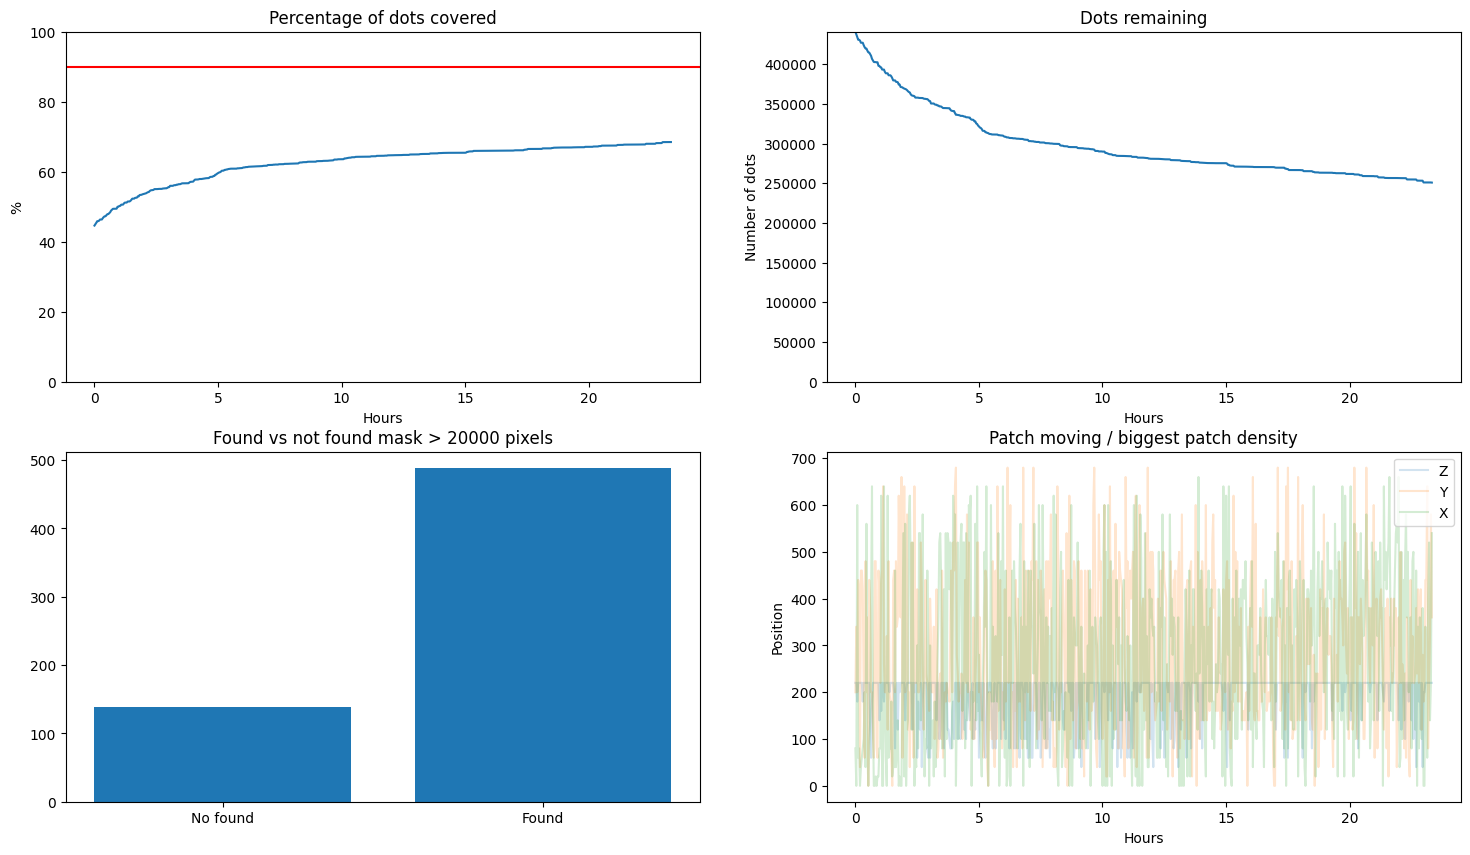

In [148]:
time_line = np.linspace(0, 23.33, num=len(dp))

plt.figure(figsize=(18, 10));
plt.subplot(221)
plt.plot(time_line, dp)
plt.axhline(y=90, color='r')
plt.ylim(0, 100)
plt.title("Percentage of dots covered");
plt.ylabel('%')
plt.xlabel('Hours')

plt.subplot(222)
plt.plot(time_line, dn)
plt.ylim(0, max(dn))
plt.title('Dots remaining');
plt.ylabel('Number of dots')
plt.xlabel('Hours')

plt.subplot(223)
x = ['No found', 'Found']
y = [np.count_nonzero(np.array(mf)), len(mf)-np.count_nonzero(np.array(mf))]
plt.bar(x, y);
plt.title('Found vs not found mask > 20000 pixels')


plt.subplot(224)
plt.plot(time_line, pz, alpha=0.2)
plt.plot(time_line, py, alpha=0.2)
plt.plot(time_line, px, alpha=0.2)
plt.ylabel('Position')
plt.xlabel('Hours');
plt.legend(['Z', 'Y', 'X'])
plt.title('Patch moving / biggest patch density')
